### Import Libraries

In [87]:
import polars as pl
from statsmodels.regression.mixed_linear_model import MixedLM
from tabulate import tabulate
from scipy.stats import wilcoxon, ttest_rel, shapiro, stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Daten Vorbereiten
Importieren der Files

In [88]:
questionaires_raw = pl.read_csv("questionaires.csv")
question_results_raw = pl.read_csv("questionResults.csv")
test_condition_orders_raw = pl.read_csv("testConditionOrders.csv")
interaction_data_raw = pl.read_csv("recordingDatabase.csv")
fav = pl.read_csv("FAV.csv")

# drop rows where PersonID is = 0 or 23, because 0 was for testing and 23 did not do the learning evaluation
questionaires = questionaires_raw.filter(pl.col("PersonID") != 0).filter(pl.col("PersonID") != 23)
question_results = question_results_raw.filter(pl.col("PersonID") != 0).filter(pl.col("PersonID") != 23)
test_condition_orders = test_condition_orders_raw.filter(pl.col("PersonID") != 0).filter(pl.col("PersonID") != 23)
interaction_data = interaction_data_raw.filter(pl.col("PersonID") != 0).filter(pl.col("PersonID") != 23)

### Definition der Skalen 

In [89]:
# define questions for the different scales/items

efficiancy_questions = [
    "Zum Lernen empfinde ich die Anwendung als:",
]
learning_question = [
    "Ich konnte gut mit dem LLM-Agenten lernen",
]

information_question = [
    "Ich konnte die Informationen gut verstehen",
]

stimulation_questions = [
    "Die Beschäftigung mit der Lernanwendung empfinde ich als:",
]
visual_question = [
    "Die Gestaltung des LLM-Agenten hat mir gefallen",
]

motivation_questions = [
    "Der LLM-Agent hat mich Motiviert",
]

social_questions = [
    "Ich hatte das Gefühl mit einer Person in der virtuellen Umgebung zu interagieren statt mit einer Computer-Simulation",
]

Sprachassistent = [
    "Die Antworten und Fragen des LLM-Agenten sind:",
]
Nützlichkeit = [
    "Die Möglichkeit die Lernanwendung zu nutzen empfinde ich als:",
]
Rolle_Motivator = [
    "Die Nennung des meines eigenen Namens während der Nutzung empfand ich als motivierend",
]
Rolle_Organisator = [
    "Die Möglichkeit mir durch den LLM-Agenten Komponenten markieren zu lassen war nützlich",
]
Rolle_Tutor = [
    "Durch die Abfrage des LLM Agenten konnte ich die Komponenten gut lernen",
]

Rolle_Tutor2 = [
    "Die Zusammenfassung meiner Lernsession hat mir beim Lernen geholfen.",
]


### Erstellen der Scores

#### für gesamt UX

In [90]:
# Sprachassistent-Score berechnen
Antwortqualität = (
    questionaires.filter(pl.col("Question").is_in(Sprachassistent))
    .group_by(["PersonID"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Antwortqualität"))
 ).with_columns(
     (pl.col("Antwortqualität")/4).alias("Antwortqualität")
    )

# Nützlichkeit-Score berechnen
Nützlichkeit_df = (
    questionaires.filter(pl.col("Question").is_in(Nützlichkeit))
    .group_by(["PersonID"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Nützlichkeit"))
 ).with_columns(
     (pl.col("Nützlichkeit")/4).alias("Nützlichkeit")
     )

# Rolle_Motivator-Score berechnen
Rolle_Motivator_score = (
    questionaires.filter(pl.col("Question").is_in(Rolle_Motivator))
    .group_by(["PersonID"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Rolle_Motivator_Score"))
)

# Rolle_Organisator-Score berechnen
Rolle_Organisator_score = (
    questionaires.filter(pl.col("Question").is_in(Rolle_Organisator))
    .group_by(["PersonID"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Rolle_Organisator_Score"))
)

# Rolle_Tutor-Score berechnen
Rolle_Tutor_score = (
    questionaires.filter(pl.col("Question").is_in(Rolle_Tutor))
    .group_by(["PersonID"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Rolle_Tutor_Score"))
)

# Rolle_Tutor2-Score berechnen
Rolle_Tutor2_score = (
    questionaires.filter(pl.col("Question").is_in(Rolle_Tutor2))
    .group_by(["PersonID"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Rolle_Tutor2_Score"))
)

#### für Conditions

In [91]:
efficiancy_score = (
    questionaires.filter(pl.col("Question").is_in(efficiancy_questions))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Efficiancy_Score"))
 ).with_columns(
     (pl.col("Efficiancy_Score") / 4).alias("Effizienz Wertung")
 )

stimulation_score = (
    questionaires.filter(pl.col("Question").is_in(stimulation_questions))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Stimulation_Score"))
).with_columns(
    (pl.col("Stimulation_Score") / 4).alias("Stimulations Wertung")
)

Lerneffizienz = (
    questionaires.filter(pl.col("Question").is_in(learning_question))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Lerneffizienz"))
)

Informationsverständnis = (
    questionaires.filter(pl.col("Question").is_in(information_question))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Informationsverständnis"))
)

Gestaltung = (
    questionaires.filter(pl.col("Question").is_in(visual_question))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Gestaltung"))
)

social_score = (
    questionaires.filter(pl.col("Question").is_in(social_questions))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Soziale Präsenz"))
)

Motivation = (
    questionaires.filter(pl.col("Question").is_in(motivation_questions))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Motivation"))
)

### Cronbachs Alpha für die einzelnen Conditions

In [92]:
def cronbach_alpha(df):
    item_variances = df.var(axis=0, ddof=1)
    total_variances = df.sum(axis=1).var(ddof=1)
    number_of_items = len(item_variances)
    return (number_of_items / (number_of_items - 1)) * (1 - item_variances.sum() / total_variances)

def calculate_cronbach_for_conditions(df, conditions, scale_name):
    for cond in conditions:
        df_cond = df[df["Condition"] == cond]
        if df_cond.empty:
            print(f"Keine Daten für Condition: {cond}")
            continue
        df_pivot = df_cond.pivot(index='PersonID', columns='left', values='Answer')
        alpha = cronbach_alpha(df_pivot).round(2)
        print(f"Cronbach's Alpha for {scale_name} in {cond}: {alpha}")


# Definiere alle Conditions in einer Liste
conditions_list = ["ECA + Audio", "ECA + kein Audio", "UI + Audio", "UI + kein Audio"]


efficiancy_questions_df = questionaires.filter(pl.col("Question").is_in(efficiancy_questions))
efficiancy_questions_df = efficiancy_questions_df.drop("Question", "right").to_pandas()

calculate_cronbach_for_conditions(efficiancy_questions_df, conditions_list, "Efficiancy")

stimulation_questions_df = questionaires.filter(pl.col("Question").is_in(stimulation_questions))
stimulation_questions_df = stimulation_questions_df.drop("Question", "right").to_pandas()

calculate_cronbach_for_conditions(stimulation_questions_df, conditions_list, "Stimulation")




Cronbach's Alpha for Efficiancy in ECA + Audio: 0.76
Cronbach's Alpha for Efficiancy in ECA + kein Audio: 0.7
Cronbach's Alpha for Efficiancy in UI + Audio: 0.38
Cronbach's Alpha for Efficiancy in UI + kein Audio: 0.39
Cronbach's Alpha for Stimulation in ECA + Audio: 0.98
Cronbach's Alpha for Stimulation in ECA + kein Audio: 0.94
Cronbach's Alpha for Stimulation in UI + Audio: 0.85
Cronbach's Alpha for Stimulation in UI + kein Audio: 0.89


### Cronbachs Alpha für die Kombinierten Conditions

In [93]:
combined_conditions = ["ECA + Audio", "UI + Audio"]
df_combined = efficiancy_questions_df[efficiancy_questions_df["Condition"].isin(combined_conditions)]

df_combined = df_combined.groupby(["PersonID", "left"]).agg({"Answer": "mean"}).reset_index()
df_pivot_combined = df_combined.pivot(index='PersonID', columns='left', values='Answer')
alpha_combined = cronbach_alpha(df_pivot_combined)
print(f"Cronbach's Alpha for Efficiancy in {combined_conditions}: {alpha_combined}")

combined_conditions = ["ECA + kein Audio", "UI + kein Audio"]
df_combined = efficiancy_questions_df[efficiancy_questions_df["Condition"].isin(combined_conditions)]

df_combined = df_combined.groupby(["PersonID", "left"]).agg({"Answer": "mean"}).reset_index()
df_pivot_combined = df_combined.pivot(index='PersonID', columns='left', values='Answer')
alpha_combined = cronbach_alpha(df_pivot_combined)
print(f"Cronbach's Alpha for Efficiancy in {combined_conditions}: {alpha_combined}")

combined_conditions = ["ECA + Audio", "ECA + kein Audio"]
df_combined = efficiancy_questions_df[efficiancy_questions_df["Condition"].isin(combined_conditions)]

df_combined = df_combined.groupby(["PersonID", "left"]).agg({"Answer": "mean"}).reset_index()
df_pivot_combined = df_combined.pivot(index='PersonID', columns='left', values='Answer')
alpha_combined = cronbach_alpha(df_pivot_combined)
print(f"Cronbach's Alpha for Efficiancy in {combined_conditions}: {alpha_combined}")

combined_conditions = ["UI + Audio", "UI + kein Audio"]
df_combined = efficiancy_questions_df[efficiancy_questions_df["Condition"].isin(combined_conditions)]

df_combined = df_combined.groupby(["PersonID", "left"]).agg({"Answer": "mean"}).reset_index()
df_pivot_combined = df_combined.pivot(index='PersonID', columns='left', values='Answer')
alpha_combined = cronbach_alpha(df_pivot_combined)
print(f"Cronbach's Alpha for Efficiancy in {combined_conditions}: {alpha_combined}")


Cronbach's Alpha for Efficiancy in ['ECA + Audio', 'UI + Audio']: 0.6992264172728323
Cronbach's Alpha for Efficiancy in ['ECA + kein Audio', 'UI + kein Audio']: 0.6028985507246376
Cronbach's Alpha for Efficiancy in ['ECA + Audio', 'ECA + kein Audio']: 0.7845472591235302
Cronbach's Alpha for Efficiancy in ['UI + Audio', 'UI + kein Audio']: 0.4579549940781682


### Cronbachs Alpha für Nützlichkeit und Sprachassistent Score

In [94]:
# nützlichkeit
nützlichkeit_questions_df = questionaires.filter(pl.col("Question").is_in(Nützlichkeit))
nützlichkeit_questions_df = nützlichkeit_questions_df.drop("Question", "right").to_pandas()
df_piviot_nützlichkeit = nützlichkeit_questions_df.pivot(index='PersonID', columns='left', values='Answer')

cronbach_alpha_nützlichkeit = cronbach_alpha(df_piviot_nützlichkeit)

# Sprachassistent
Sprachassistent_questions_df = questionaires.filter(pl.col("Question").is_in(Sprachassistent))
Sprachassistent_questions_df = Sprachassistent_questions_df.drop("Question", "right").to_pandas()
df_piviot_Sprachassistent = Sprachassistent_questions_df.pivot(index='PersonID', columns='left', values='Answer')
cronbach_alpha_Sprachassitent = cronbach_alpha(df_piviot_Sprachassistent)

# print
print(f"Cronbach's Alpha for Nützlichkeit: {cronbach_alpha_nützlichkeit}")
print(f"Cronbach's Alpha for Sprachassistent: {cronbach_alpha_Sprachassitent}")



Cronbach's Alpha for Nützlichkeit: 0.9812293382641339
Cronbach's Alpha for Sprachassistent: 0.7748031496062993


### Zusammenfügen der Scores in eine Tabelle

#### Gesamt UX

In [95]:
# Gesamtscores berechnen und zusammenführen
final_ux_scores = (
    Antwortqualität.join(Nützlichkeit_df, on=["PersonID"], how="inner")
    .join(Rolle_Motivator_score, on=["PersonID"], how="inner")
    .join(Rolle_Organisator_score, on=["PersonID"], how="inner")
    .join(Rolle_Tutor_score, on=["PersonID"], how="inner")
    .join(Rolle_Tutor2_score, on=["PersonID"], how="inner")
)

# Condition Tabelle erstellen
condition_ux_scores = efficiancy_score.join(
    stimulation_score, 
    on=["PersonID", "Condition"], 
    how="inner").join(social_score, 
    on=["PersonID", "Condition"], 
    how="inner").join(Motivation, 
    on=["PersonID", "Condition"], 
    how="inner").join(Lerneffizienz,
    on=["PersonID", "Condition"],
    how="inner").join(Gestaltung,
    on=["PersonID", "Condition"],
    how="inner").join(Informationsverständnis,
    on=["PersonID", "Condition"],
    how="inner")
condition_ux_scores = condition_ux_scores.filter(pl.col("Condition").is_not_null())

#### Conditions

In [96]:
# Calculeate combined UX Score for each person and condition
condition_ux_scores = condition_ux_scores.with_columns(
    (pl.col("Effizienz Wertung").cast(float) + 
     pl.col("Stimulations Wertung").cast(float)).alias("UX_Score") 
)
# ux score min max normalization
condition_ux_scores = condition_ux_scores.with_columns(
    ((pl.col("UX_Score") - pl.col("UX_Score").min()) / (pl.col("UX_Score").max() - pl.col("UX_Score").min())).alias("Normalized_UX_Score")
)

### Hinzufügen der Testresults
Jetzt werden zu der Condition Tabelle noch die Lernergebnisse hinzugefügt. Dafür werden zuerst die Tabellen vorbereitet:

In [97]:
# Remove the PreTest questions
question_results = question_results_raw.filter(pl.col("TestCondition").eq("PostTest"))
test_condition_orders = test_condition_orders_raw.unique()

test_condition_orders_exploded = (
    test_condition_orders.with_columns(
        Components=pl.col("Components").str.extract_all(r"(\d+)")
    )
    .explode("Components")
    .with_columns(pl.col("Components").cast(pl.Int64).alias("Component"))
).select("PersonID", "Condition", "Component")

# Entfernen von Duplikaten in test_condition_orders_exploded
test_condition_orders_exploded = test_condition_orders_exploded.unique()

# Entfernen von Duplikaten in question_results
question_results = question_results.unique(subset=["PersonID", "CorrectComponent", "TestCondition"])
question_results.filter(question_results.is_duplicated())

learning_results = question_results.join(
    test_condition_orders_exploded,
    left_on=["PersonID", "CorrectComponent"],
    right_on=["PersonID", "Component"],
    how="left",
    validate="1:1",
)

assert learning_results["Condition"].null_count() == 0



und anschließend zusammengefügt

In [98]:
conditions_ux_learning = learning_results.join(
    condition_ux_scores,
    on=["PersonID", "Condition"],
    how="inner",
).drop(["TestCondition","CorrectComponent", "SelectedComponent"])


### Füge Interaktionen hinzu

In [99]:
# only count user interactions
interaction_data = interaction_data_raw.filter(pl.col("Role") == "User")

# aggregation of the data so that each person and condition has one row, if a person has no interactions in a condition, put 0
interaction_agg = interaction_data.group_by(["PersonID", "Condition"]).agg(
    pl.count("PersonID").alias("Interactions")
)


# Join the interaction data with the final scores (left join because some people might not have interactions)
conditions_ux_learning = conditions_ux_learning.join(
    interaction_agg,
    on=["PersonID", "Condition"],
    how="left",
)




# Analyse

## Descriptive Statistik

### UX Scores, Combined UX Score, Testresult by Condition

In [100]:
# Aggregation der Daten pro Person und Condition
agg_df = conditions_ux_learning.group_by(['PersonID', 'Condition']).agg([
    pl.mean("TestResult").alias("TestResult"),
    pl.mean("Effizienz Wertung").alias("Effizienz Wertung"),
    pl.mean("Stimulations Wertung").alias("Stimulations Wertung"),
    pl.mean("Soziale Präsenz").alias("Soziale Präsenz"),
    pl.mean("Motivation").alias("Motivation"),
    pl.mean("Lerneffizienz").alias("subjektiver Lernerfolg"),
    pl.mean("Gestaltung").alias("Gestaltung"),
    pl.mean("Informationsverständnis").alias("Informationsverständnis"),
    pl.mean("Normalized_UX_Score").alias("UX_Score")
])

# Liste der abhängigen Variablen
variables = ["TestResult",
                "Effizienz Wertung",
                "Stimulations Wertung",
                "Soziale Präsenz", 
                "Motivation",
                "subjektiver Lernerfolg",
                "Gestaltung",
                "Informationsverständnis", 
                "UX_Score"]

# Daten in langes Format bringen
long_df = agg_df.unpivot(
    index=["PersonID", "Condition"],
    on=variables,
    variable_name="Variable",
    value_name="Value"
)

# Berechnung der Statistiken
stats_df = long_df.group_by(["Variable", "Condition"]).agg([
    pl.median("Value").alias("Median").round(2),
    pl.mean("Value").alias("Mean").round(2),
    pl.std("Value").alias("StdDev").round(2),
    pl.count("Value").alias("Count").round(2)
])


In [101]:
stats_df_pd = stats_df.to_pandas()
stats_df_pd = stats_df_pd.sort_values(by=["Variable", "Condition"])

# Um die mehrzeiligen Zeilen für die AV zu erstellen, fügen wir eine Spalte hinzu, die nur beim ersten Auftreten der AV den Namen enthält
stats_df_pd['Variable_Label'] = stats_df_pd['Variable']
stats_df_pd.loc[stats_df_pd.duplicated(subset=['Variable']), 'Variable_Label'] = ''


# Reihenfolge der Spalten festlegen
stats_df_pd_all = stats_df_pd[['Variable_Label', 'Condition', 'Median', 'Mean', 'StdDev', 'Count']]


### Styling Graphes

In [102]:
sns.set_theme(style="whitegrid")
sns.set_style("whitegrid")
my_pal = {"ECA + Audio": "#F57C00", 
          "UI + Audio": "#00FFBB", 
          "ECA + kein Audio": "#652CB3", 
          "UI + kein Audio": "#4C8491", 
          "Audio" : "#FFFB00", 
          "Kein Audio" : "#79F824",
          "ECA" : "#E80D1F",
          "UI" : "#1e88e5",
          "Antwortqualität" : "#484D6D",
          "Nützlichkeit" : "#E7A977",
          "Namensnennung" : "#95190C",
          "Highlighting Funktion" : "#3EC300",
          "Abfrage Funktion" : "#CEFF1A",
          "Lernzusammenfassung" : "#C61E5E",
          }

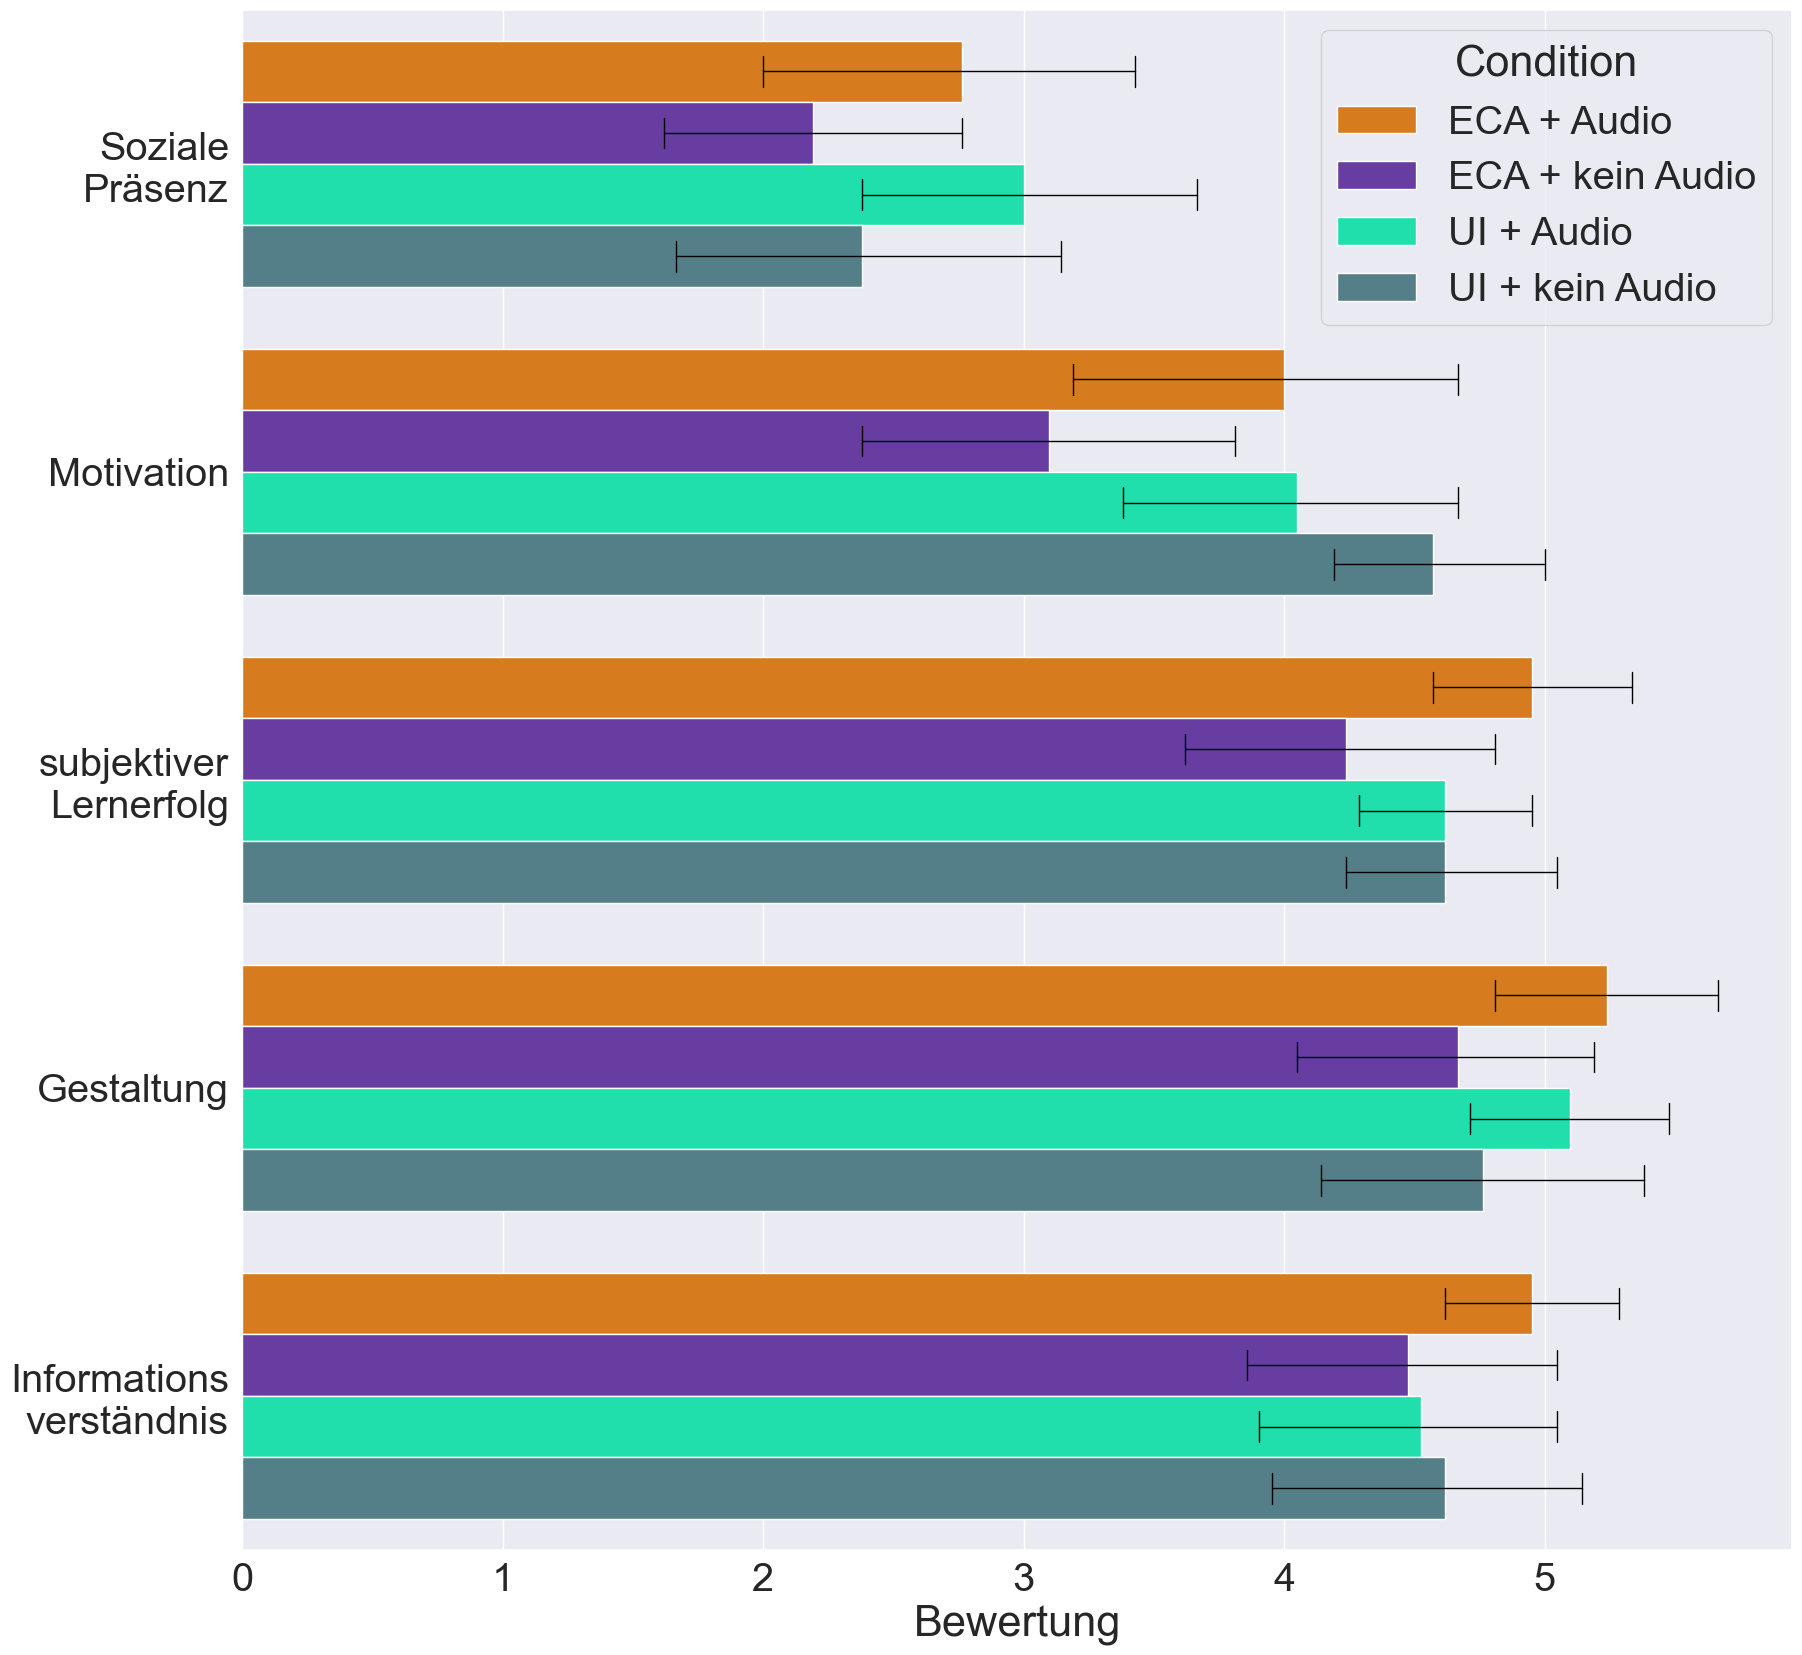

In [136]:
new_df = long_df.filter(~pl.col("Variable").is_in(["UX_Score", 
                                                   "TestResult", 
                                                    "Effizienz Wertung", 
                                                   "Stimulations Wertung"]))

# order the conditions like that in dataframe order=["ECA + Audio", "ECA + kein Audio", "UI + Audio", "UI + kein Audio",],
new_df_pd = new_df.to_pandas()
new_df_pd['Condition'] = pd.Categorical(new_df_pd['Condition'], ["ECA + Audio", "ECA + kein Audio", "UI + Audio", "UI + kein Audio"])
sns.set(font_scale=2.6)

#wrap labels to avoid overlapping
new_df_pd["Variable"] = new_df_pd["Variable"].str.wrap(12)
# make as barcharts and use mean and std as error bars
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", 
            y="Variable", 
            hue="Condition", 
            data=new_df_pd, 
            palette=my_pal,
            capsize=.1,
            errwidth=1,
            errcolor="black",
            )
plt.xlabel("Bewertung")
plt.ylabel("")
plt.show()



In [104]:
# Kombinierte Conditions definieren
combined_conditions_interface = {
    "ECA": ["ECA + Audio", "ECA + kein Audio"],
    "UI": ["UI + Audio", "UI + kein Audio"],
}

combined_conditions_Audio = {
    "Audio": ["ECA + Audio", "UI + Audio"],
    "Kein Audio": ["ECA + kein Audio", "UI + kein Audio"]
}   

# Neue Spalte für kombinierte Condition hinzufügen
def map_combined_condition(row):
    for combo_name, cond_list in combined_conditions_interface.items():
        if row["Condition"] in cond_list:
            return combo_name
    return row["Condition"]

def map_combined_condition_Audio(row):
    for combo_name, cond_list in combined_conditions_Audio.items():
        if row["Condition"] in cond_list:
            return combo_name
    return row["Condition"]

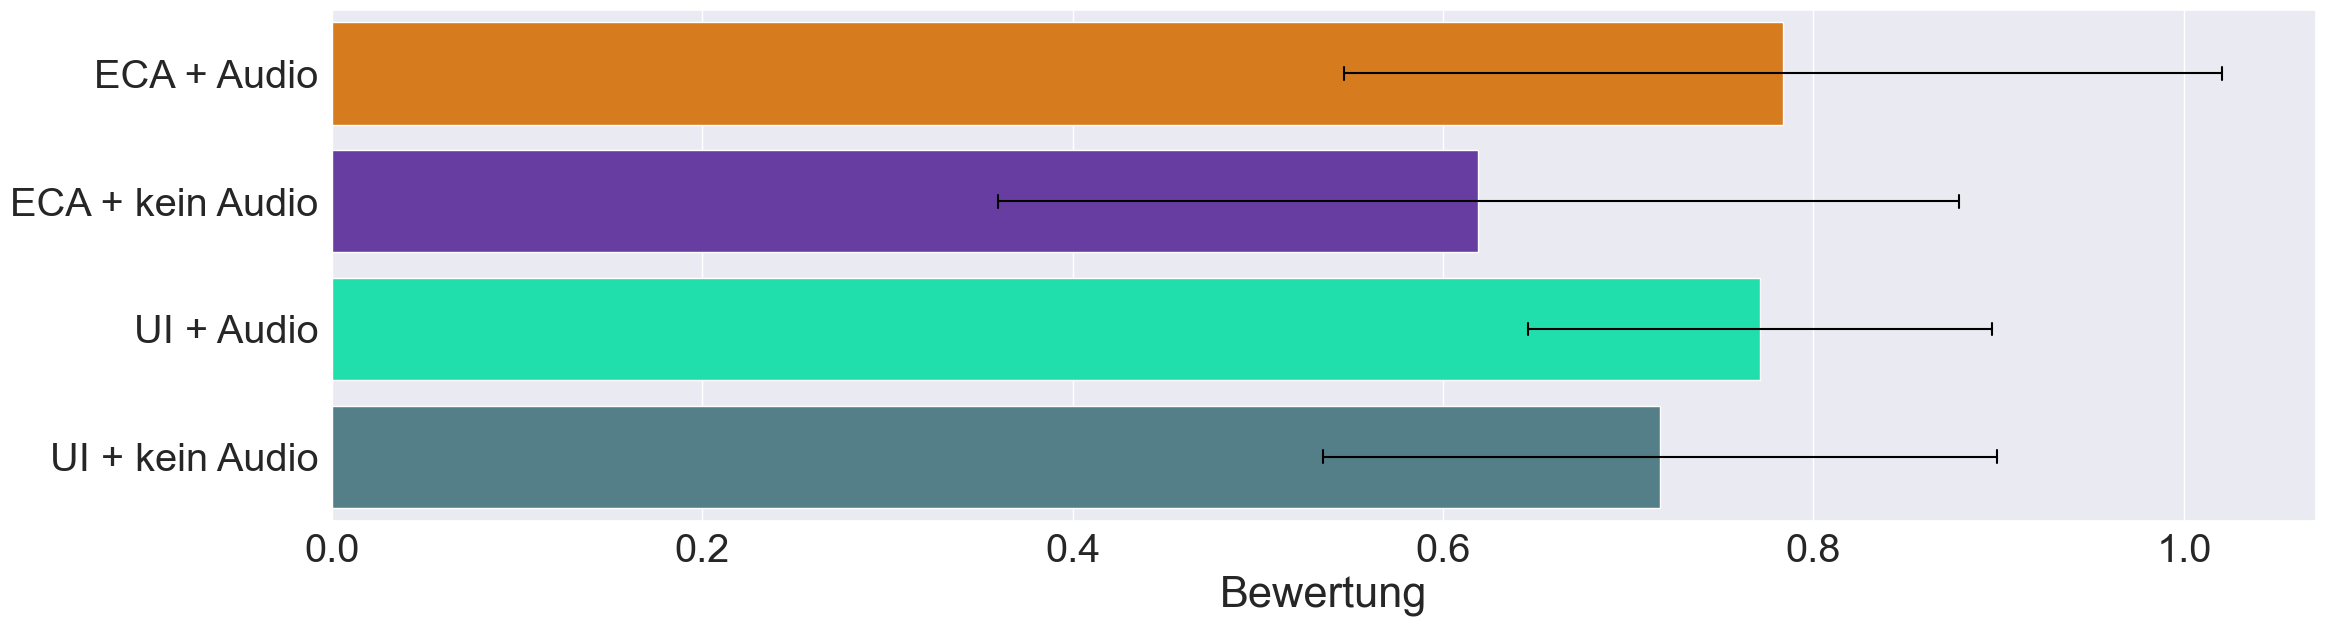

+----+-------------------------+------------------+----------+--------+----------+---------+
|    | Variable_Label          | Condition        |   Median |   Mean |   StdDev |   Count |
|----+-------------------------+------------------+----------+--------+----------+---------|
| 30 | Effizienz Wertung       | ECA + Audio      |     3.25 |   3.31 |     0.58 |      21 |
| 20 |                         | ECA + kein Audio |     3    |   3    |     0.63 |      21 |
|  2 |                         | UI + Audio       |     3    |   3.04 |     0.44 |      21 |
| 35 |                         | UI + kein Audio  |     3    |   3.08 |     0.51 |      21 |
| 24 | Gestaltung              | ECA + Audio      |     6    |   5.24 |     1.04 |      21 |
|  0 |                         | ECA + kein Audio |     5    |   4.67 |     1.39 |      21 |
| 17 |                         | UI + Audio       |     5    |   5.1  |     0.89 |      21 |
| 34 |                         | UI + kein Audio  |     5    |   4.76 

In [105]:
# Filter die relevanten Variablen und Originaldaten
filtered_long_df = long_df.filter(pl.col("Variable").is_in(["UX_Score"]))

# Füge die kombinierten Conditions hinzu
filtered_long_df_pd = filtered_long_df.to_pandas()

# ---- 1. Boxplots für einzelne Conditions ----
plt.figure(figsize=(24, 7
                    ))
ax = sns.barplot(
    data=filtered_long_df_pd,
    x="Value", 
    y="Condition",
    #hue="Condition",
    palette=my_pal,
    order=["ECA + Audio", "ECA + kein Audio", "UI + Audio", "UI + kein Audio"],
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()
plt.show()


# print a table with the statistics
print(tabulate(stats_df_pd_all, headers='keys', tablefmt='psql'))

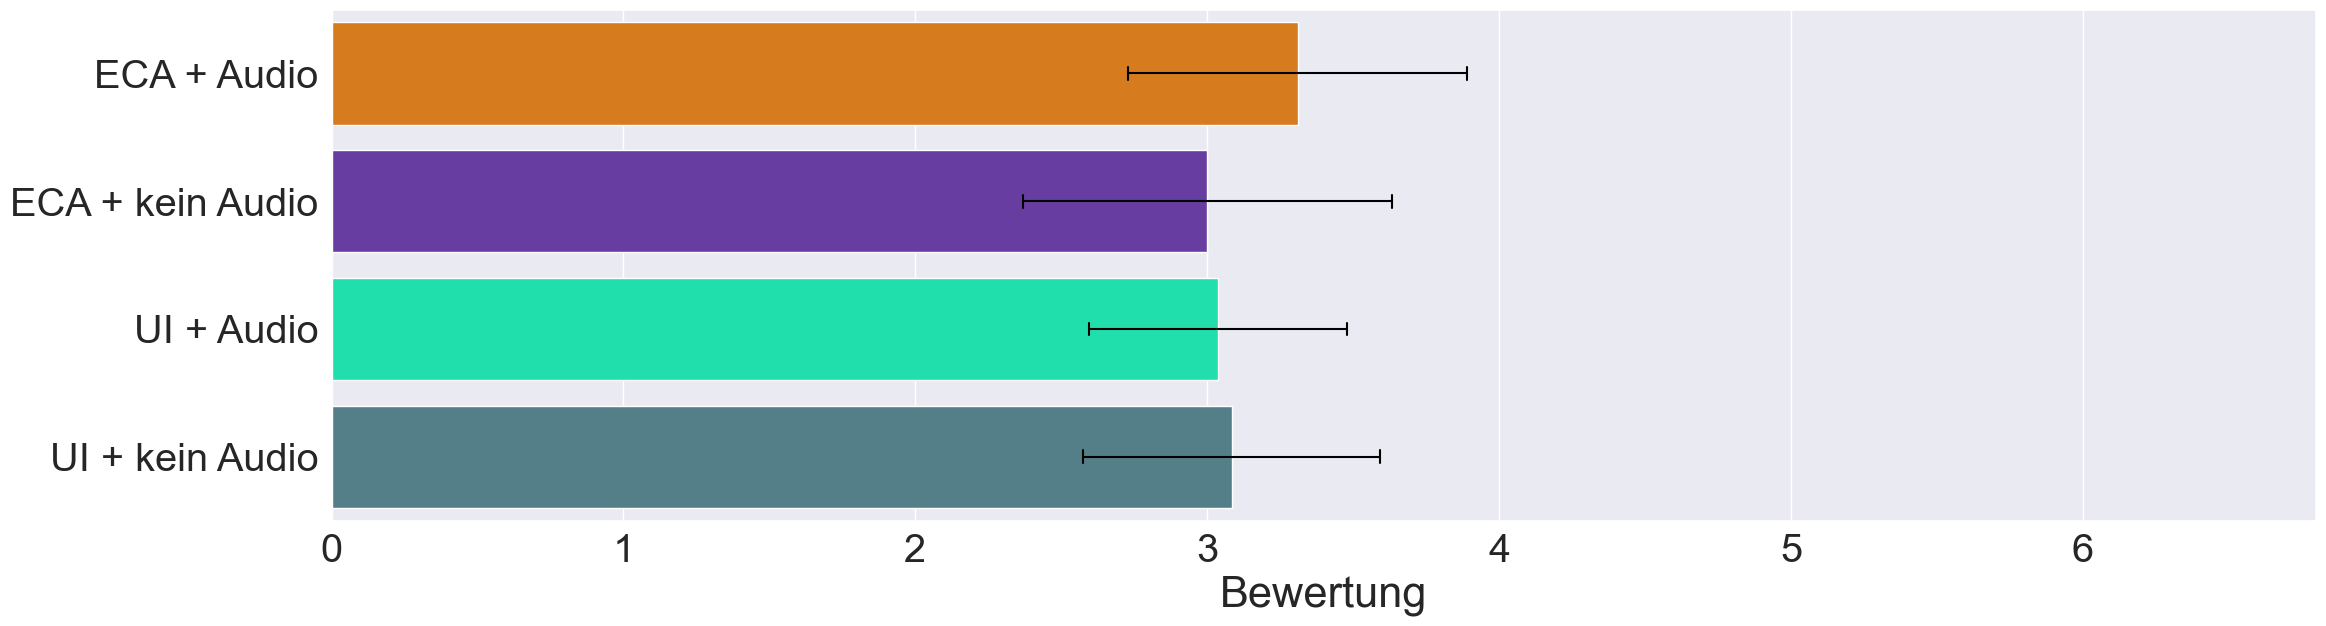

In [106]:
# Filter die relevanten Variablen und Originaldaten
filtered_long_df = long_df.filter(pl.col("Variable").is_in(["Effizienz Wertung"]))

# make sure x axis has always values from 0 to 6
plt.figure(figsize=(24, 7))
sns.barplot(
    data=filtered_long_df.to_pandas(),
    x="Value", 
    y="Condition",
    #hue="Condition",
    palette=my_pal,
    order=["ECA + Audio", "ECA + kein Audio", "UI + Audio", "UI + kein Audio"],
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlim(0, 6.8)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()
plt.show()

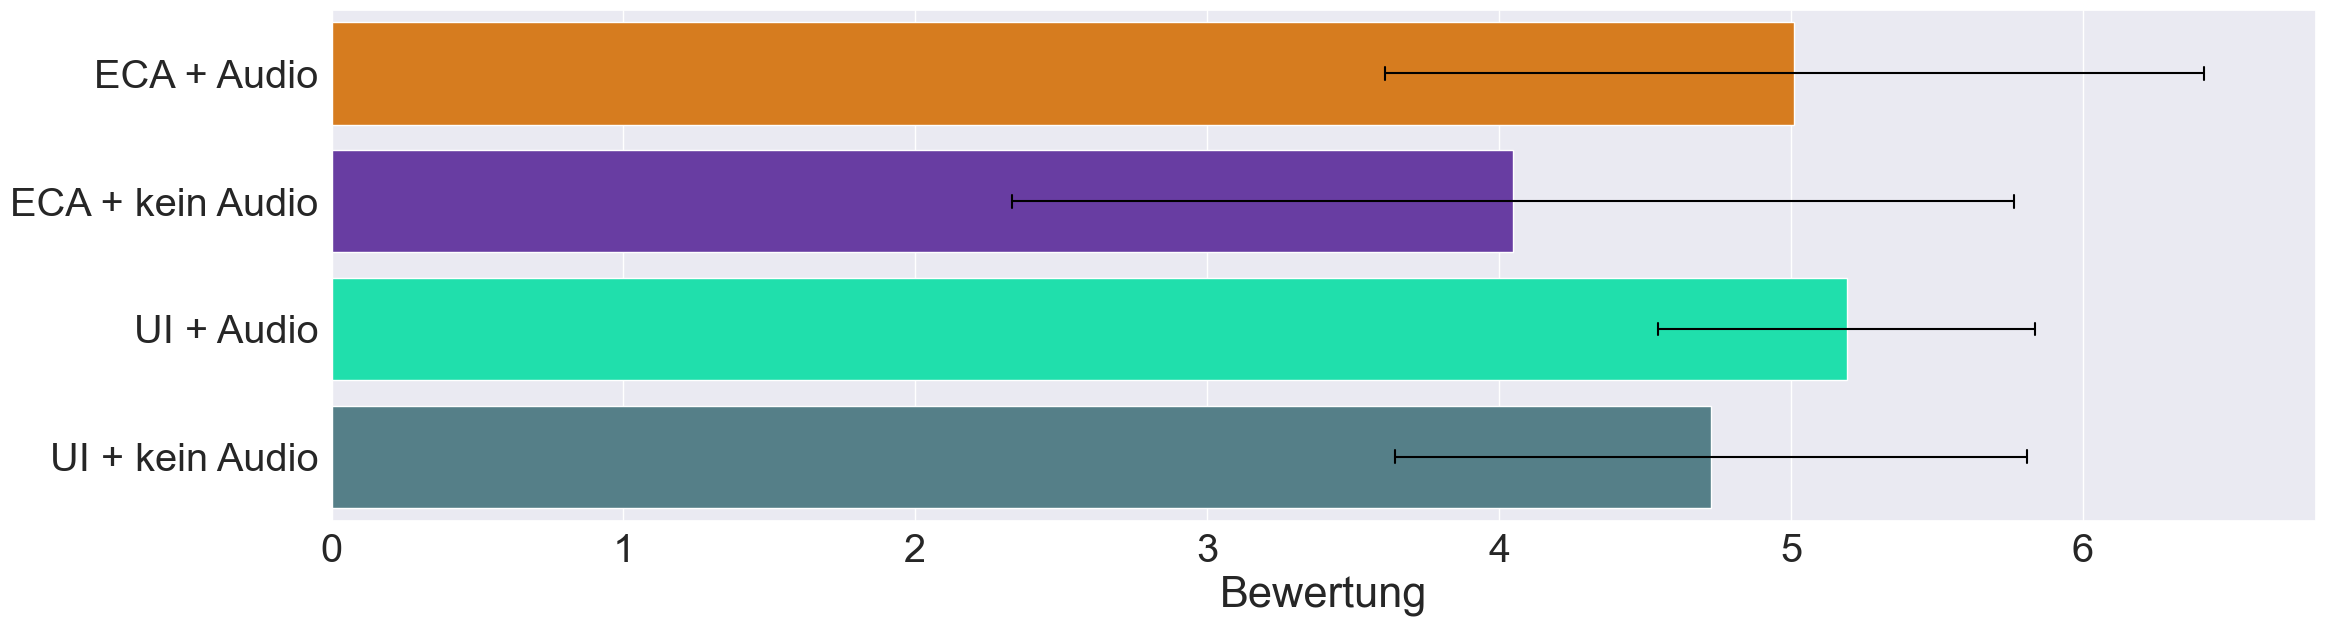

In [107]:
# Filter die relevanten Variablen und Originaldaten
filtered_long_df = long_df.filter(pl.col("Variable").is_in(["Stimulations Wertung"]))

# ---- 1. Boxplots für einzelne Conditions ----
plt.figure(figsize=(24, 7))
sns.barplot(
    data=filtered_long_df.to_pandas(),
    x="Value", 
    y="Condition",
    #hue="Condition",
    palette=my_pal,
    order=["ECA + Audio","ECA + kein Audio", "UI + Audio", "UI + kein Audio", ],
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlim(0, 6.8)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()
plt.show()

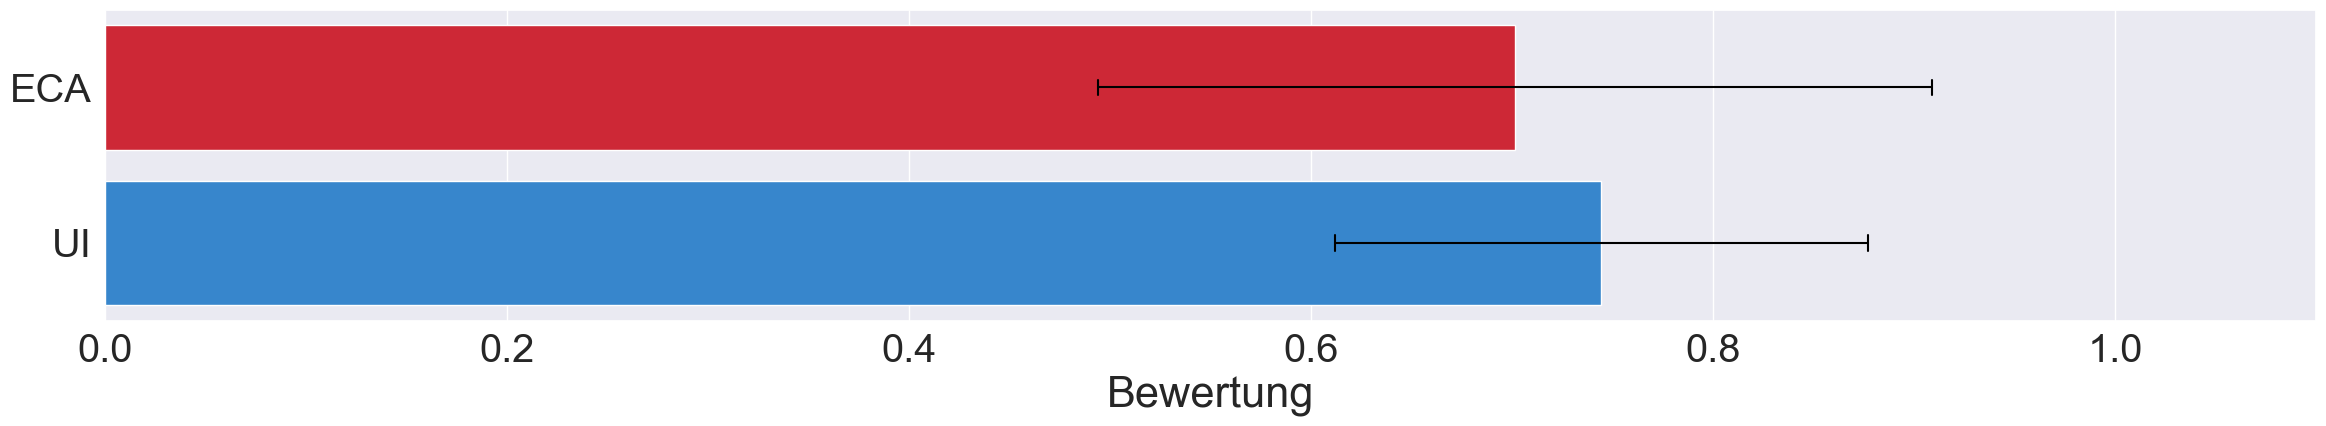

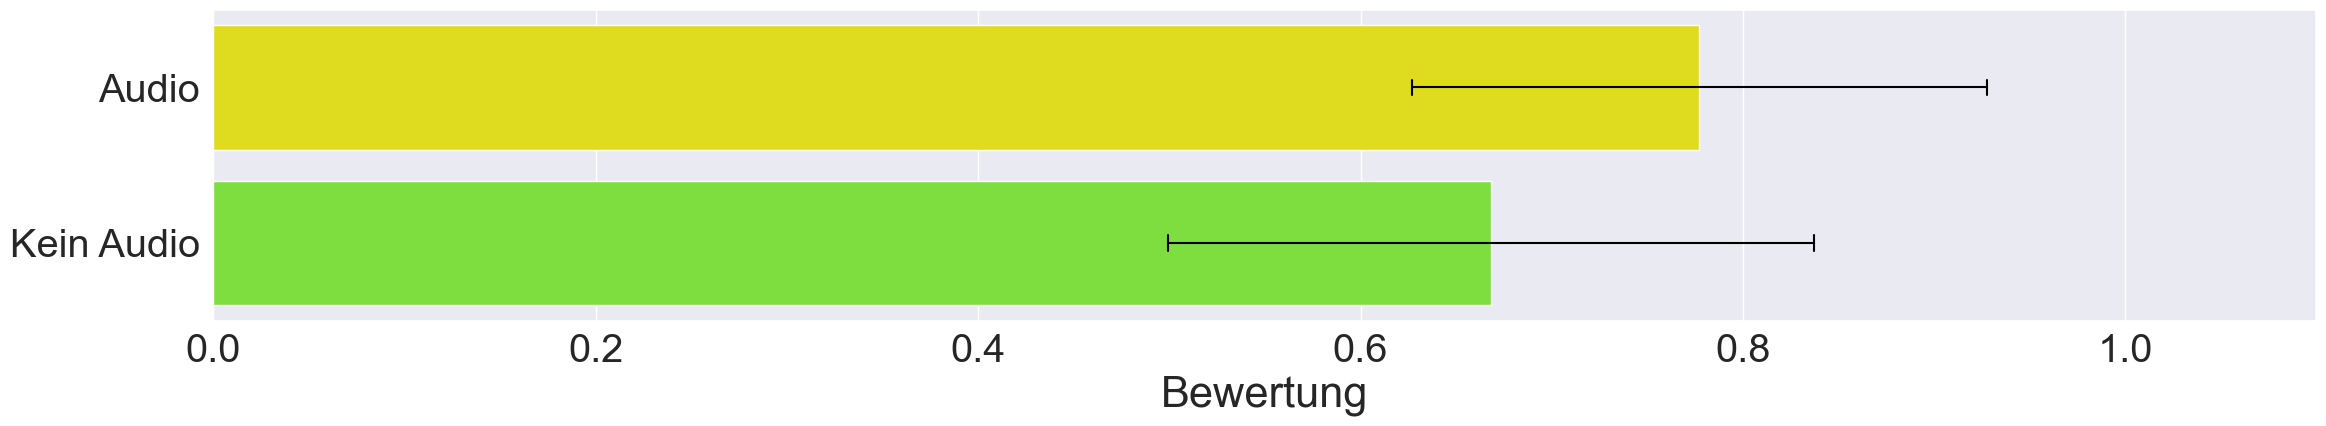

  Combined_Condition  count      mean       std       min  max
0                ECA     21  0.701229  0.207471  0.112903  1.0
1                 UI     21  0.744240  0.132640  0.467742  1.0
  Combined_Condition  count      mean       std       min  max
0              Audio     21  0.777266  0.150322  0.387097  1.0
1         Kein Audio     21  0.668203  0.168822  0.435484  1.0


In [131]:
filtered_long_df = long_df.filter(pl.col("Variable").is_in(["UX_Score"]))

filtered_long_df_pd = filtered_long_df.to_pandas()
interface_combined = filtered_long_df_pd.copy()
interface_combined["Combined_Condition"] = filtered_long_df_pd.apply(map_combined_condition, axis=1)
# select only the relevant columns
interface_combined = interface_combined[["PersonID", "Combined_Condition", "Value"]]
interface_combined = interface_combined.groupby(["PersonID", "Combined_Condition"]).agg({"Value": "mean"}).reset_index()

# Boxplots für kombinierte Conditions erstellen
plt.figure(figsize=(24, 5))
sns.barplot(
    data=interface_combined,
    x="Value",
    y="Combined_Condition",
    #hue="Combined_Condition",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlim(0, 1.1)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Konvertierung nach Pandas und hinzufügen der Combined Condition
Audio_combined = filtered_long_df_pd.copy()
Audio_combined["Combined_Condition"] = filtered_long_df_pd.apply(map_combined_condition_Audio, axis=1)
# select only the relevant columns
Audio_combined = Audio_combined[["PersonID", "Combined_Condition", "Value"]]
Audio_combined = Audio_combined.groupby(["PersonID", "Combined_Condition"]).agg({"Value": "mean"}).reset_index()

# Boxplots für kombinierte Conditions erstellen
plt.figure(figsize=(24, 5))
sns.barplot(
    data=Audio_combined,
    x="Value",
    y="Combined_Condition",
    #hue="Combined_Condition",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlim(0, 1.1)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()
plt.show()


# Beispiel für interface_combined
table_interface = (
    interface_combined
    .groupby("Combined_Condition")["Value"]
    .agg(["count", "mean", "std", "min", "max"])
    .reset_index()
)

print(table_interface)

table_Audio = (
    Audio_combined
    .groupby("Combined_Condition")["Value"]
    .agg(["count", "mean", "std", "min", "max"])
    .reset_index()
)

print(table_Audio)



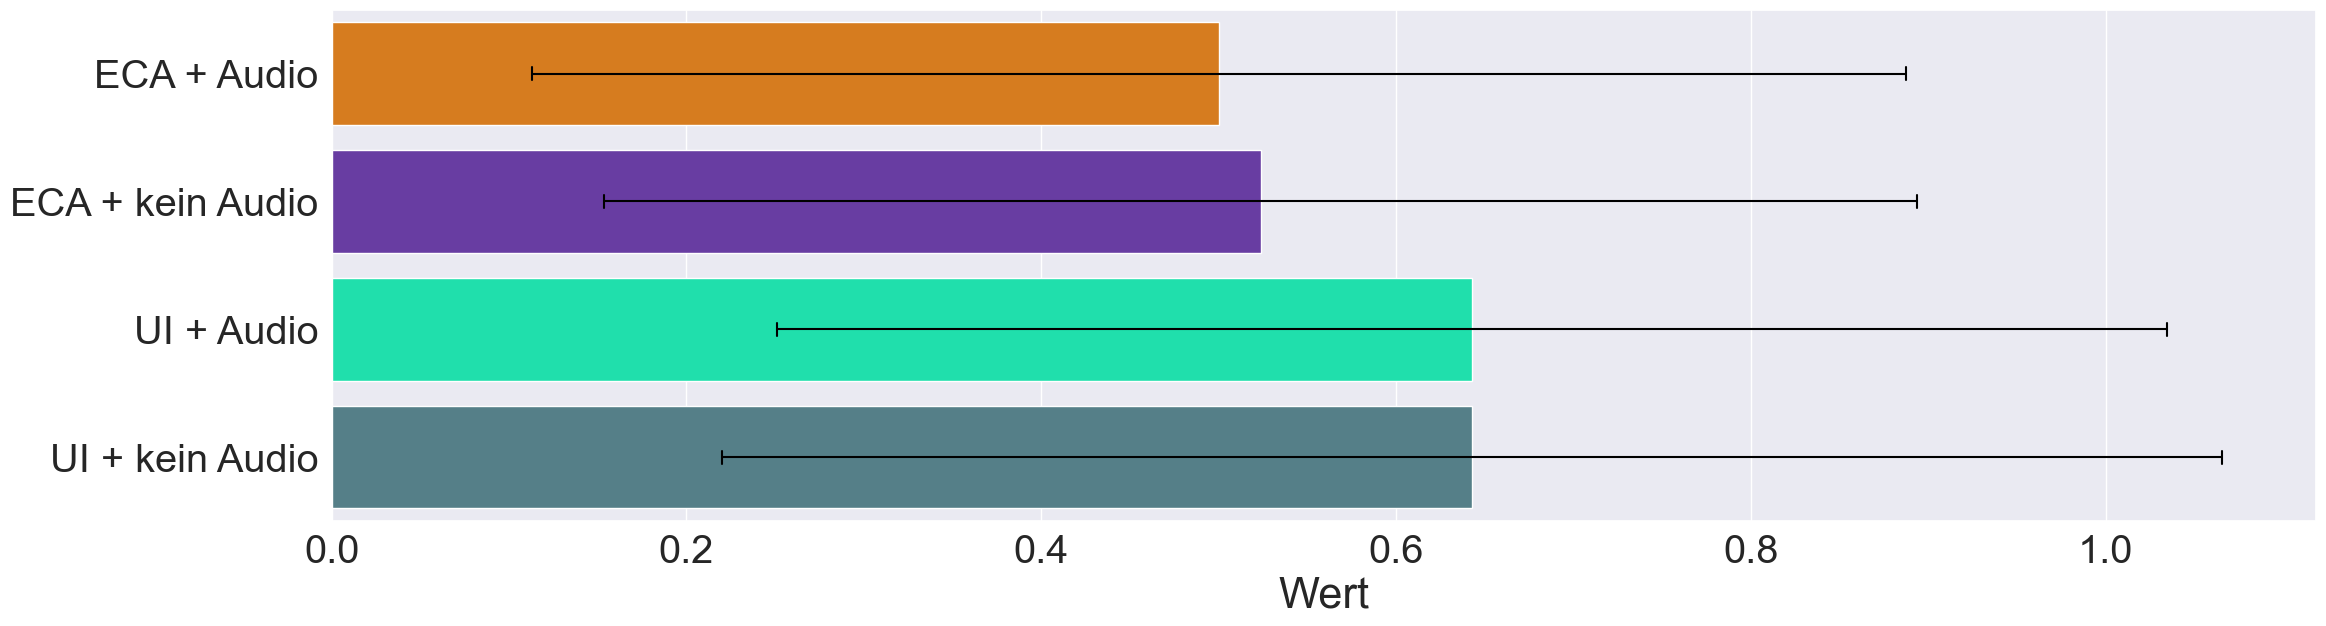

          Condition  count      mean       std  min  max
0       ECA + Audio     21  0.500000  0.387298  0.0  1.0
1  ECA + kein Audio     21  0.523810  0.370006  0.0  1.0
2        UI + Audio     21  0.642857  0.391882  0.0  1.0
3   UI + kein Audio     21  0.642857  0.422577  0.0  1.0


In [109]:
filtered_long_df_testResult = long_df.filter(pl.col("Variable").is_in(["TestResult"]))
# make bar chart for TestResult
plt.figure(figsize=(24, 7))
sns.barplot(
    data=filtered_long_df_testResult.to_pandas(),
    x="Value",
    y="Condition",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
    order=["ECA + Audio", "ECA + kein Audio", "UI + Audio", "UI + kein Audio"],
)
plt.xlabel("Wert")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Ersrtelle eine Tabelle mit den Testergebnissen
table_testResult = (
    filtered_long_df_testResult.to_pandas()
    .groupby("Condition")["Value"]
    .agg(["count", "mean", "std", "min", "max"])
    .reset_index()
)

print(table_testResult)

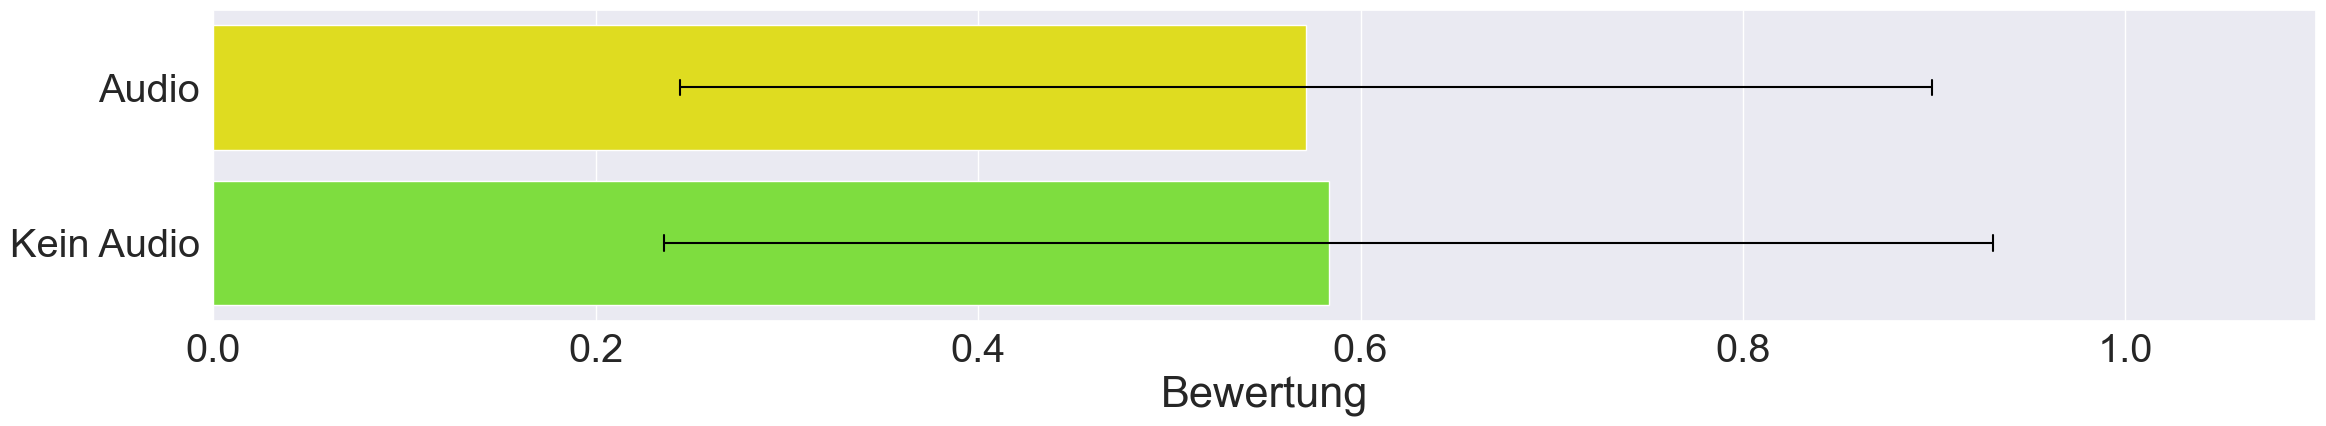

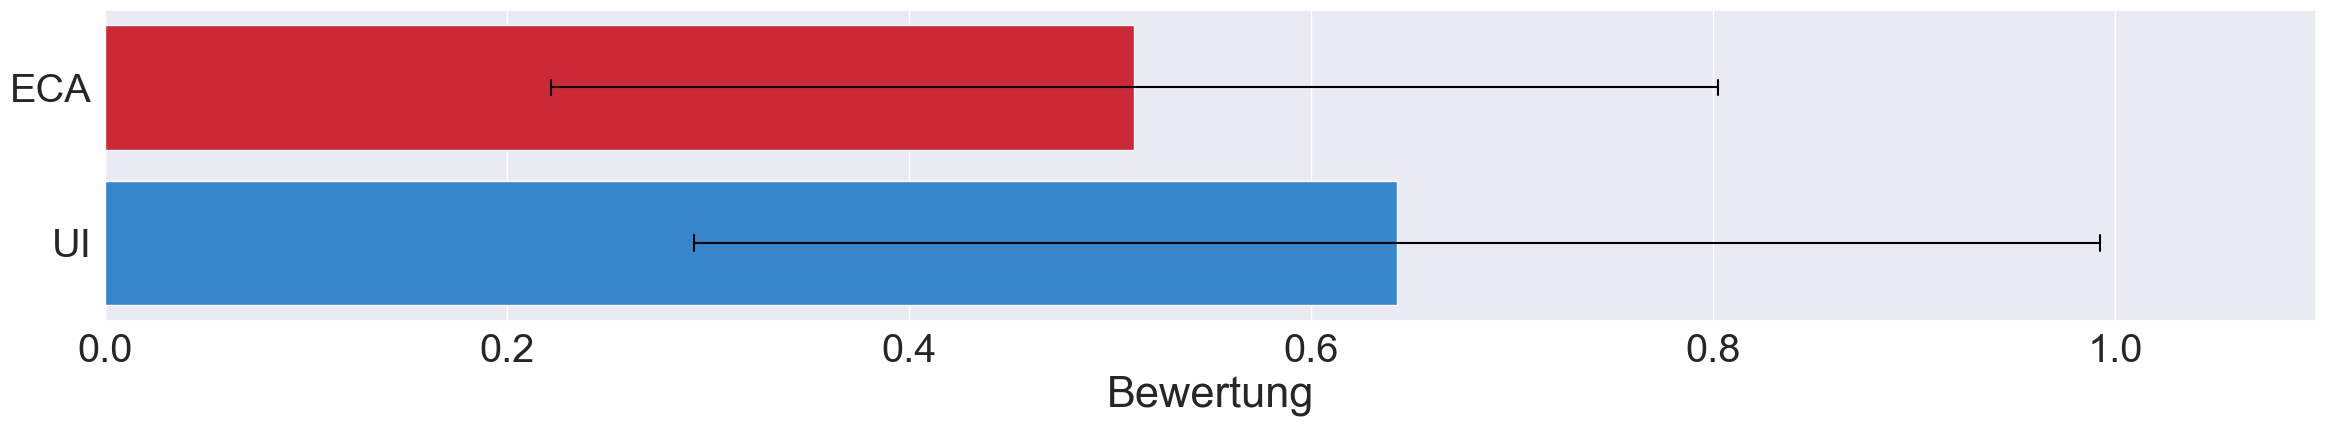

  Combined_Condition  median  mean   std  count
0                ECA    0.50  0.51  0.29     21
1                 UI    0.75  0.64  0.35     21
  Combined_Condition  median  mean   std  count
0              Audio    0.75  0.57  0.33     21
1         Kein Audio    0.75  0.58  0.35     21


In [132]:
# make bar chart for combined conditions

Audio_combined_testResult = filtered_long_df_testResult.to_pandas().copy()
Audio_combined_testResult["Combined_Condition"] = Audio_combined_testResult.apply(map_combined_condition_Audio, axis=1)

# select only the relevant columns
Audio_combined_testResult = Audio_combined_testResult[["PersonID", "Combined_Condition", "Value"]]
Audio_combined_testResult = Audio_combined_testResult.groupby(["PersonID", "Combined_Condition"]).agg({"Value": "mean"}).reset_index()

plt.figure(figsize=(24, 5))
sns.barplot(
    data=Audio_combined_testResult,
    x="Value",
    y="Combined_Condition",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlim(0, 1.1)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()
plt.show()


interface_combined_testResult = filtered_long_df_testResult.to_pandas().copy()
interface_combined_testResult["Combined_Condition"] = interface_combined_testResult.apply(map_combined_condition, axis=1)
# select only the relevant columns
interface_combined_testResult = interface_combined_testResult[["PersonID", "Combined_Condition", "Value"]]
interface_combined_testResult = interface_combined_testResult.groupby(["PersonID", "Combined_Condition"]).agg({"Value": "mean"}).reset_index()
# make bar chart for combined conditions
plt.figure(figsize=(24,5 ))
sns.barplot(
    data=interface_combined_testResult,
    x="Value",
    y="Combined_Condition",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlim(0, 1.1)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()
plt.show()

# Tabelle
table_interface_testResult = (
    interface_combined_testResult
    .groupby("Combined_Condition")["Value"]
    .agg(["median", "mean", "std", "count"]).round(2)
    .reset_index()
)
print(table_interface_testResult)

table_Audio_testResult = (
    Audio_combined_testResult
    .groupby("Combined_Condition")["Value"]
    .agg(["median", "mean", "std","count"]).round(2)
    .reset_index()
)
print(table_Audio_testResult)

In [111]:

# beim fav datensatz, wenn "ECA + Audio" mach ECA, wenn "UI + Audio" mach UI
fav_combined = fav.to_pandas()
fav_combined["Favorite Condition"] = fav_combined["Condition"].apply(lambda x: "ECA" if x == "ECA + Audio" else "UI")
fav_combined = fav_combined[["PersonID", "Favorite Condition"]]

df_wide = interface_combined_testResult.pivot(
    index="PersonID", 
    columns="Combined_Condition", 
    values="Value"
)

df_wide.head()


pref = fav_combined.groupby('PersonID')['Favorite Condition'].first()


df_wide = df_wide.join(pref, on='PersonID', how='left')
df_wide.head()
df_wide["Diff_UI_minus_ECA"] = df_wide["UI"] - df_wide["ECA"]


In [112]:
def get_better_condition(row):
    if row["Diff_UI_minus_ECA"] > 0:
        return "UI"
    elif row["Diff_UI_minus_ECA"] < 0:
        return "ECA"
    else:
        return "Equal"

df_wide["ActuallyBetter"] = df_wide.apply(get_better_condition, axis=1)


df_wide["PrefMatch"] = (df_wide["Favorite Condition"] == df_wide["ActuallyBetter"])

df_wide["PrefMatch"].value_counts()
pct_match = df_wide["PrefMatch"].mean() * 100
print(f"{pct_match:.2f}% der Teilnehmenden haben die Bedingung bevorzugt, in der sie tatsächlich besser waren.")
df_wide.groupby("Favorite Condition")["Diff_UI_minus_ECA"].describe()

crosstab = pd.crosstab(
    df_wide["Favorite Condition"],   # Zeilen
    df_wide["ActuallyBetter"]       # Spalten
)
print(crosstab)




33.33% der Teilnehmenden haben die Bedingung bevorzugt, in der sie tatsächlich besser waren.
ActuallyBetter      ECA  Equal  UI
Favorite Condition                
ECA                   4      4   8
UI                    0      2   3


### Interactions by Condition

In [113]:

interaction_stats = conditions_ux_learning.group_by("Condition").agg(
    pl.median("Interactions").alias("Median"),
    pl.mean("Interactions").alias("Mean"),
    pl.std("Interactions").alias("StdDev"),
    pl.count("Interactions").alias("Count")
)
# round the values to 2 decimal places
interaction_stats = interaction_stats.with_columns(
    pl.col("Median").round(2).alias("Median"),
    pl.col("Mean").round(2).alias("Mean"),
    pl.col("StdDev").round(2).alias("StdDev")
)
print(interaction_stats)

shape: (4, 5)
┌──────────────────┬────────┬───────┬────────┬───────┐
│ Condition        ┆ Median ┆ Mean  ┆ StdDev ┆ Count │
│ ---              ┆ ---    ┆ ---   ┆ ---    ┆ ---   │
│ str              ┆ f64    ┆ f64   ┆ f64    ┆ u32   │
╞══════════════════╪════════╪═══════╪════════╪═══════╡
│ UI + kein Audio  ┆ 12.0   ┆ 11.38 ┆ 7.07   ┆ 32    │
│ UI + Audio       ┆ 12.0   ┆ 15.55 ┆ 8.88   ┆ 33    │
│ ECA + kein Audio ┆ 9.0    ┆ 9.89  ┆ 6.32   ┆ 36    │
│ ECA + Audio      ┆ 12.0   ┆ 12.2  ┆ 6.34   ┆ 35    │
└──────────────────┴────────┴───────┴────────┴───────┘


### Testresult by Interaction

              PersonID  Interactions  TestResult
PersonID      1.000000     -0.068957    0.215567
Interactions -0.068957      1.000000    0.034704
TestResult    0.215567      0.034704    1.000000
              Interactions  UX_Score
Interactions      1.000000 -0.058668
UX_Score         -0.058668  1.000000


<Axes: xlabel='Interactions', ylabel='TestResult'>

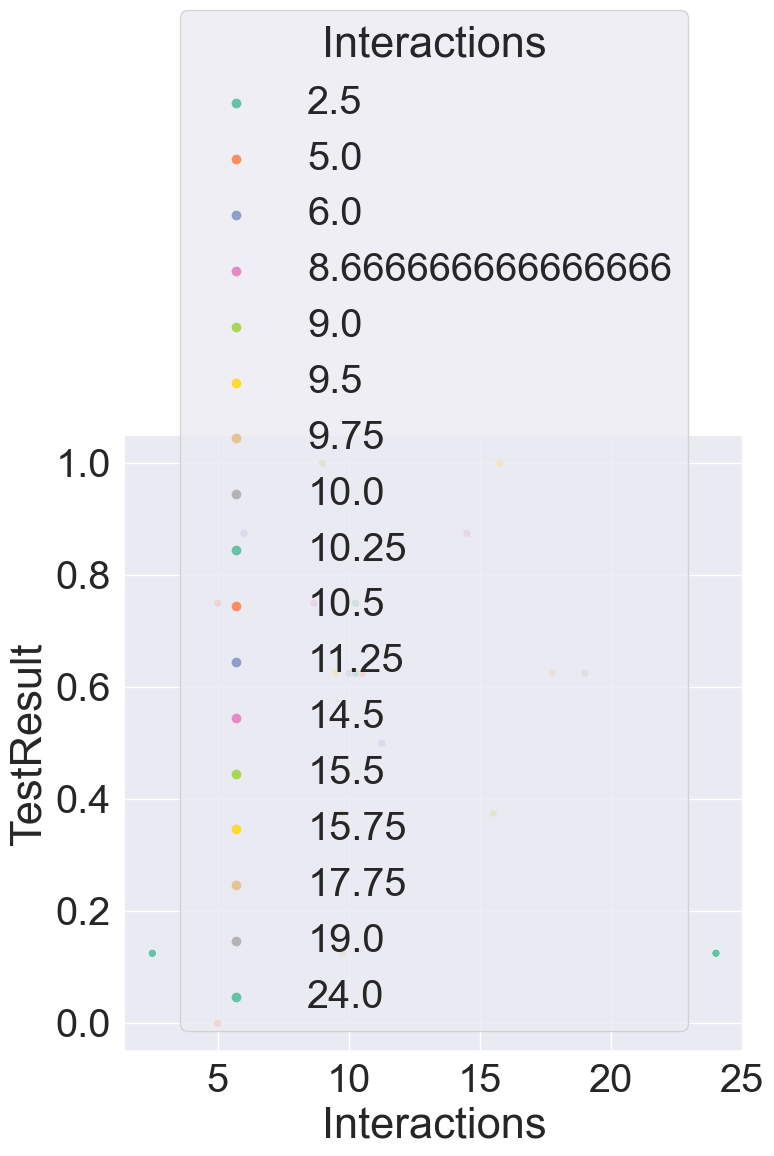

In [114]:
# Zusammenhang zwischen häufigen Interaktionen und Testergebnissen
interaction_test_ = conditions_ux_learning.select(["Interactions", "TestResult", "PersonID"]).to_pandas()
# aggregate the data for the same person 
interaction_test_ = interaction_test_.groupby(["PersonID"]).agg({
    "Interactions": "mean",
    "TestResult": "mean"
}).reset_index()

interaction_test_correlation = interaction_test_.corr()
print(interaction_test_correlation)


interaction_ux_correlation = conditions_ux_learning.select(["Interactions", "UX_Score"]).to_pandas()
interaction_ux_correlation = interaction_ux_correlation.corr()
print(interaction_ux_correlation)


plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=interaction_test_,
    x="Interactions",
    y="TestResult",
    hue="Interactions",
    palette="Set2"
)


### Gesamt UX Bewertung

In [116]:
# Aggregierte Ergebnisse ausgeben (Median, Mean, Min, Max, Std) und auf 2 Dezimalstellen runden
# Liste der interessierenden Spalten
columns = [col for col in final_ux_scores.columns if col != "PersonID"]

# Berechnung der Statistiken
stats = final_ux_scores.select([
    getattr(pl.col(col), agg)().round(2).alias(f"{agg}_{col}")
    for col in columns
    for agg in ["median", "mean", "std"]
])
# Umstrukturieren der Tabelle
tidy_stats = stats.transpose(include_header=True)
tidy_stats = tidy_stats.rename({"column": "Statistik"}).with_columns(
    pl.col("Statistik").str.extract(r"_(.+)$").alias("Skala")
)

print(tidy_stats.to_pandas().to_string())

                         Statistik  column_0                    Skala
0           median_Antwortqualität      3.00          Antwortqualität
1             mean_Antwortqualität      2.99          Antwortqualität
2              std_Antwortqualität      0.61          Antwortqualität
3              median_Nützlichkeit      5.25             Nützlichkeit
4                mean_Nützlichkeit      5.04             Nützlichkeit
5                 std_Nützlichkeit      1.33             Nützlichkeit
6     median_Rolle_Motivator_Score      5.00    Rolle_Motivator_Score
7       mean_Rolle_Motivator_Score      4.29    Rolle_Motivator_Score
8        std_Rolle_Motivator_Score      1.68    Rolle_Motivator_Score
9   median_Rolle_Organisator_Score      6.00  Rolle_Organisator_Score
10    mean_Rolle_Organisator_Score      5.81  Rolle_Organisator_Score
11     std_Rolle_Organisator_Score      0.40  Rolle_Organisator_Score
12        median_Rolle_Tutor_Score      5.00        Rolle_Tutor_Score
13          mean_Rol

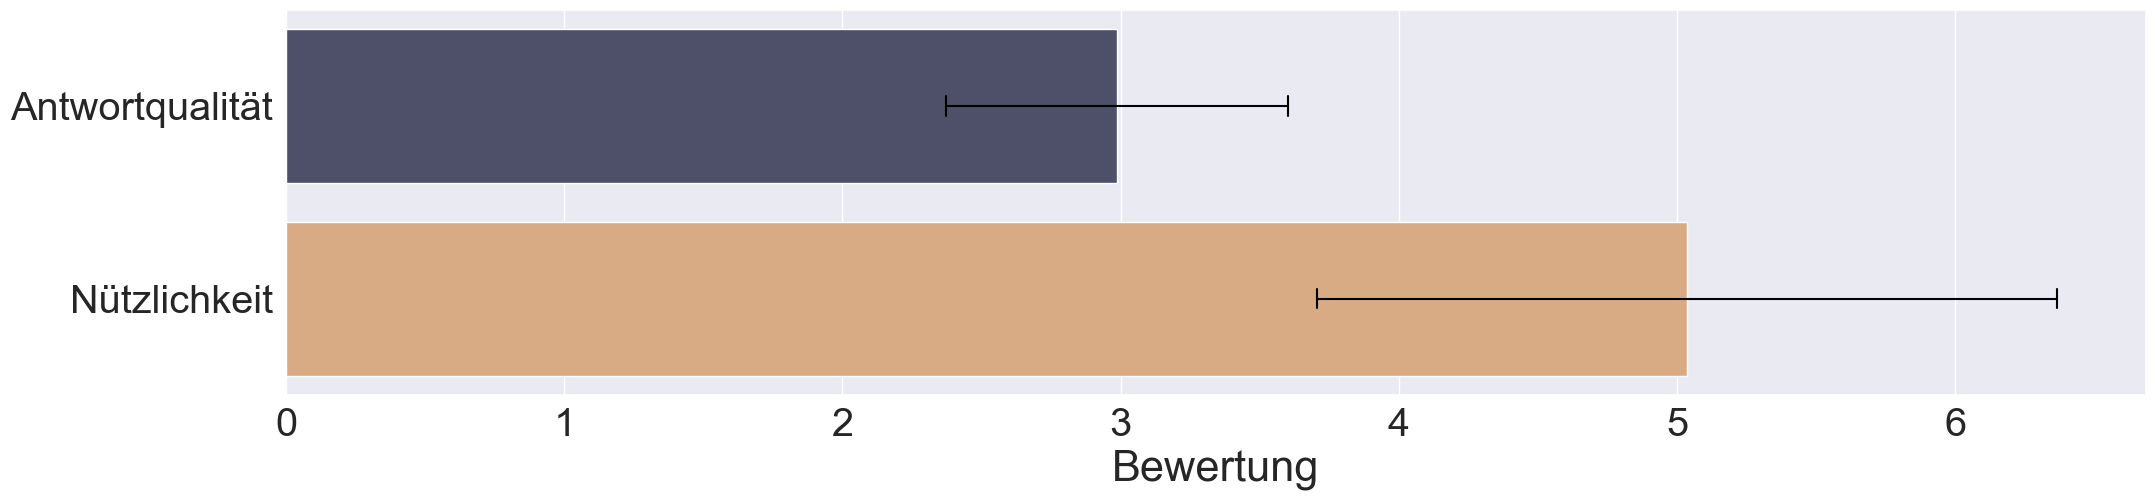

        Score_Type  median  mean   std  count
0  Antwortqualität    3.00  2.99  0.61     21
1     Nützlichkeit    5.25  5.04  1.33     21


In [133]:
# Konvertiere die Scores zu Pandas DataFrames
Antwortqualität_pd = Antwortqualität.to_pandas()
Nützlichkeit_pd = Nützlichkeit_df.to_pandas()

# Füge eine Spalte hinzu, um den Score-Typ zu kennzeichnen
Antwortqualität_pd['Score_Type'] = 'Antwortqualität'
Nützlichkeit_pd['Score_Type'] = 'Nützlichkeit'

# Benenne die Score-Spalte um, um sie zu vereinheitlichen
Antwortqualität_pd = Antwortqualität_pd.rename(columns={'Antwortqualität': 'Score'})
Nützlichkeit_pd = Nützlichkeit_pd.rename(columns={'Nützlichkeit': 'Score'})

# Kombiniere die beiden DataFrames
combined_scores = pd.concat([Antwortqualität_pd, Nützlichkeit_pd])


# Erstelle einen BarChart
plt.figure(figsize=(24,5))
sns.barplot(
    data=combined_scores,
    x="Score",
    y="Score_Type",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.show()

# tabelle
table = (
    combined_scores
    .groupby("Score_Type")["Score"]
    .agg(["median", "mean", "std", "count"]).round(2)
    .reset_index()
)
print(table)


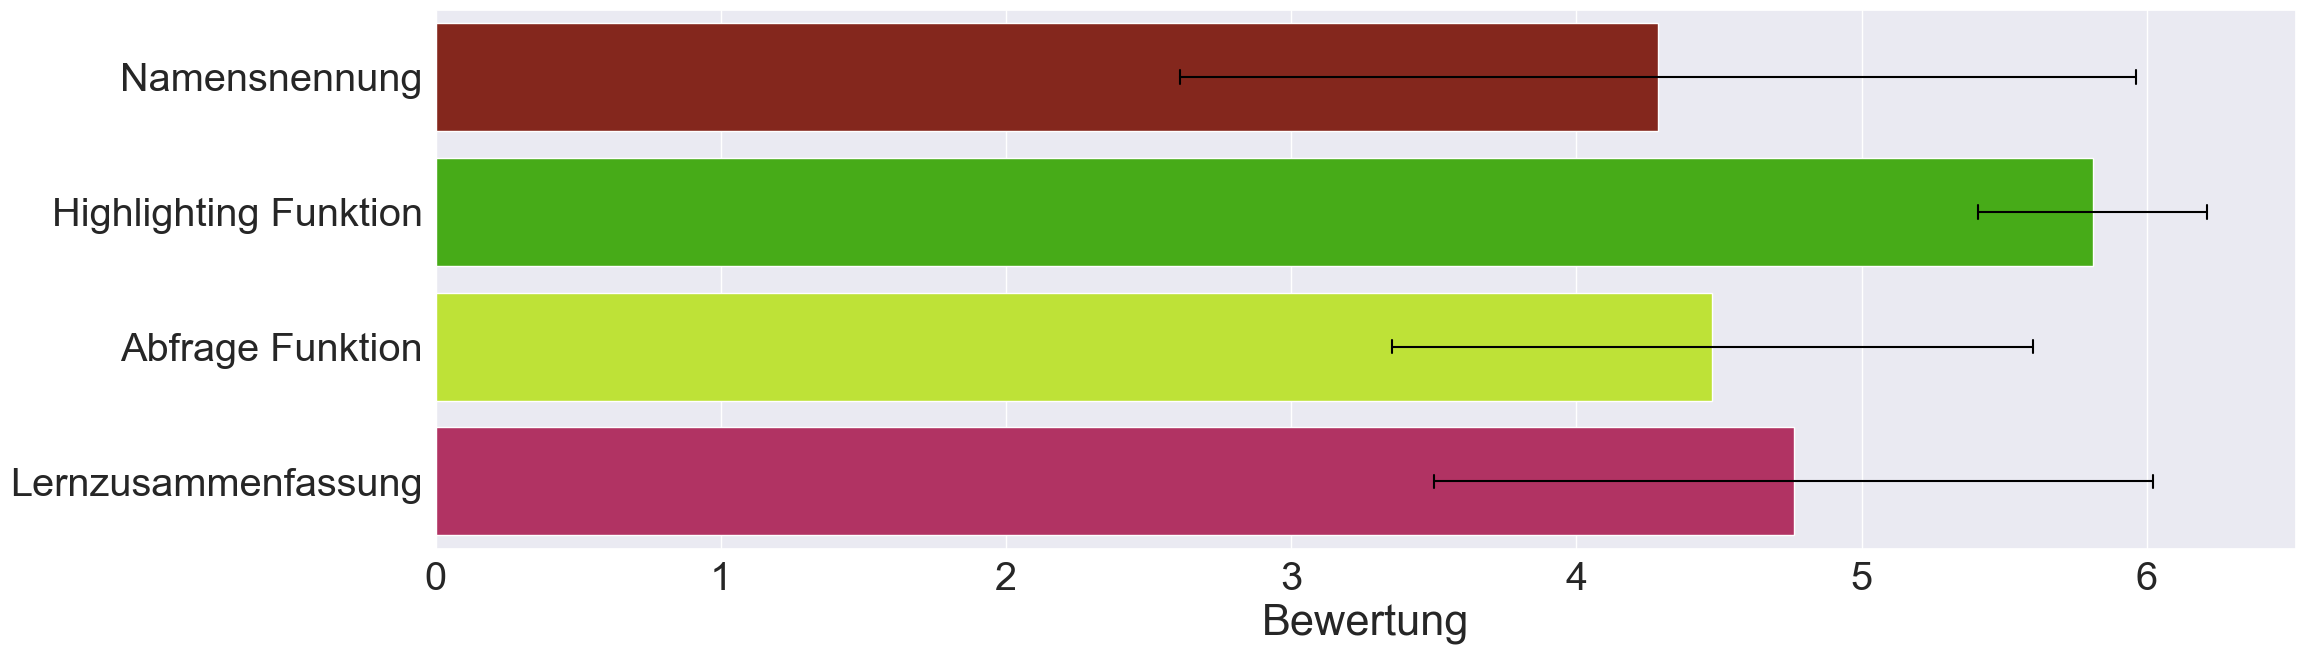

              Score_Type  median  mean   std  count
0       Abfrage Funktion     5.0  4.48  1.12     21
1  Highlighting Funktion     6.0  5.81  0.40     21
2    Lernzusammenfassung     5.0  4.76  1.26     21
3          Namensnennung     5.0  4.29  1.68     21


In [118]:
# Boxplpt für die Rollen
rolle_motivator_score_pd = Rolle_Motivator_score.to_pandas()
rolle_organisator_score_pd = Rolle_Organisator_score.to_pandas()
rolle_tutor_score_pd = Rolle_Tutor_score.to_pandas()
rolle_tutor2_score_pd = Rolle_Tutor2_score.to_pandas()

rolle_motivator_score_pd['Score_Type'] = 'Namensnennung'
rolle_organisator_score_pd['Score_Type'] = 'Highlighting Funktion'
rolle_tutor_score_pd['Score_Type'] = 'Abfrage Funktion'
rolle_tutor2_score_pd['Score_Type'] = 'Lernzusammenfassung'

rolle_motivator_score_pd = rolle_motivator_score_pd.rename(columns={'Rolle_Motivator_Score': 'Score'})
rolle_organisator_score_pd = rolle_organisator_score_pd.rename(columns={'Rolle_Organisator_Score': 'Score'})
rolle_tutor_score_pd = rolle_tutor_score_pd.rename(columns={'Rolle_Tutor_Score': 'Score'})
rolle_tutor2_score_pd = rolle_tutor2_score_pd.rename(columns={'Rolle_Tutor2_Score': 'Score'})

combined_scores = pd.concat([rolle_motivator_score_pd, rolle_organisator_score_pd, rolle_tutor_score_pd, rolle_tutor2_score_pd])

# Erstelle einen BarChart
plt.figure(figsize=(24, 7))
sns.barplot(
    data=combined_scores,
    x="Score",
    y="Score_Type",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.show()

# tabelle
table = (
    combined_scores
    .groupby("Score_Type")["Score"]
    .agg(["median", "mean", "std", "count"]).round(2)
    .reset_index()
)
print(table)


In [119]:
fav = fav.to_pandas()

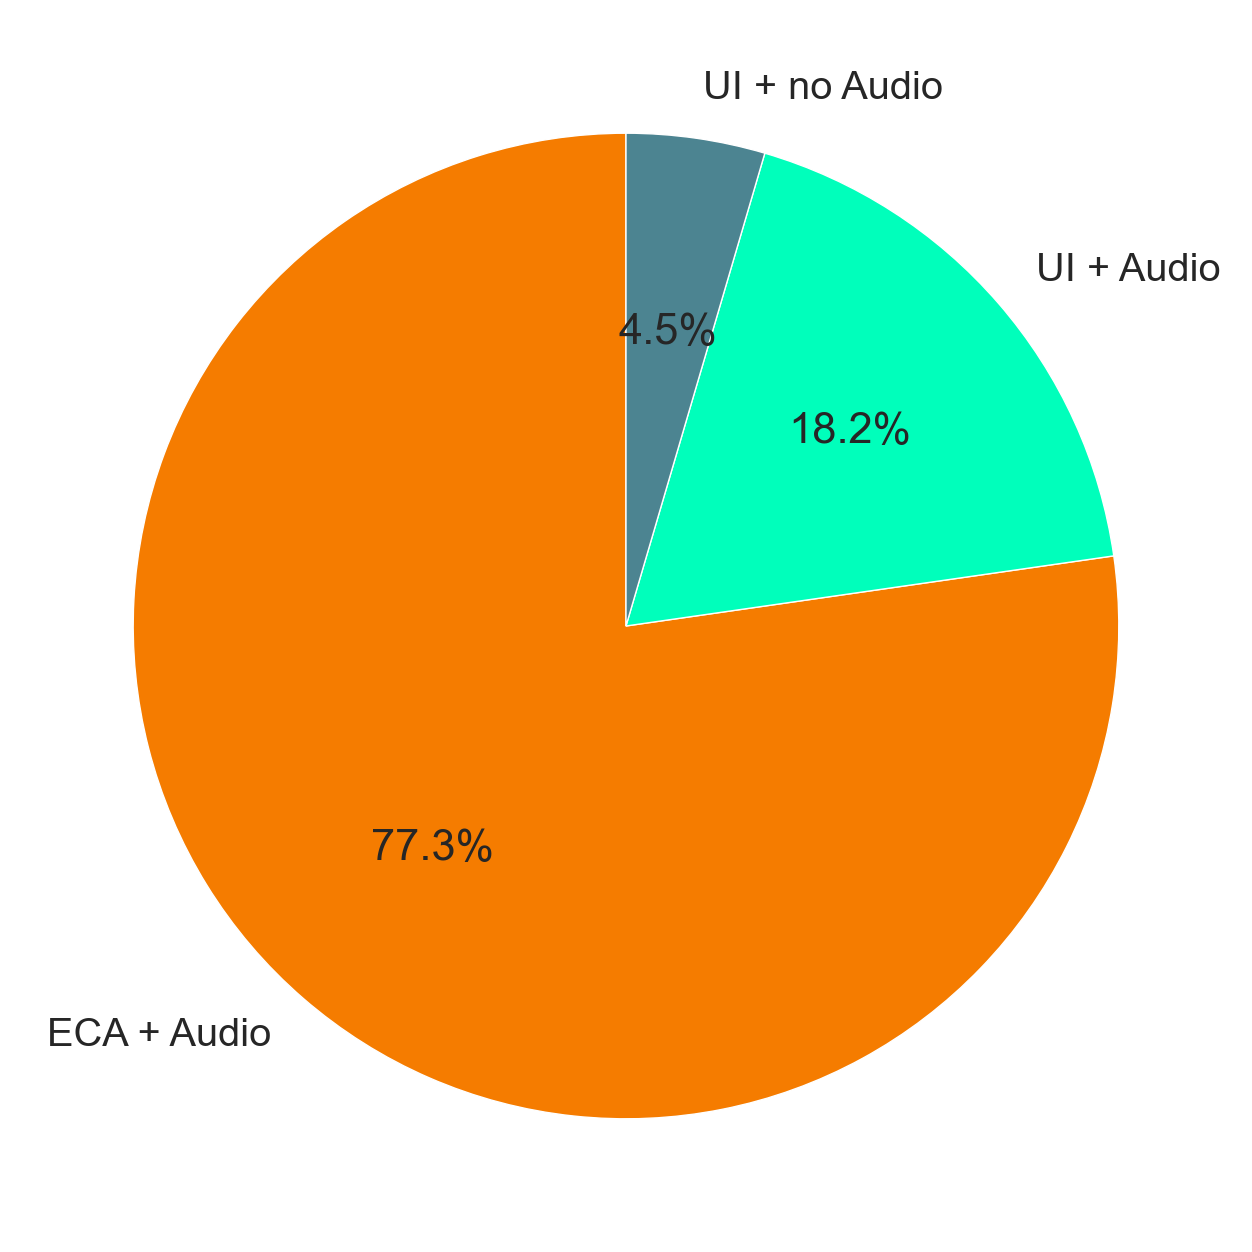

In [134]:

data = fav["Condition"].value_counts()
labels = data.index

plt.figure(figsize=(16, 16))
plt.pie(data, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=["#F57C00", "#00FFBB", "#4C8491"])
plt.show()



## Signifikanztests

## ECA und UI und Lernerfolg

In [121]:

agg_df = learning_results.group_by(['PersonID', 'Condition']).agg([
    pl.mean("TestResult").alias("TestResult"),
])


eval_data = (
    agg_df.select("PersonID", "Condition", "TestResult")
    .with_columns(
        Audio=pl.when(pl.col("Condition").str.contains("kein Audio"))
        .then(pl.lit("kein Audio"))
        .otherwise(pl.lit("Audio")),
        Interface=pl.when(pl.col("Condition").str.contains("UI"))
        .then(pl.lit("UI"))
        .otherwise(pl.lit("ECA")),
    )
    .drop("Condition")
)
df_model = eval_data.with_columns(
    Audio_No_Audio=pl.when(pl.col("Audio").eq("kein Audio")).then(1).otherwise(0),
    Interface_UI=pl.when(pl.col("Interface").eq("UI")).then(1).otherwise(0),
).to_pandas()


In [122]:


df_aggregated = df_model.groupby(["PersonID", "Interface"]).agg({"TestResult": "sum"}).reset_index()

print(df_aggregated.shape)

stat, p = wilcoxon(
    df_aggregated[df_aggregated["Interface"] == "UI"]["TestResult"],
    df_aggregated[df_aggregated["Interface"] == "ECA"]["TestResult"],alternative='two-sided', mode ='auto'
)

print('Ungerichtet Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = wilcoxon(
    df_aggregated[df_aggregated["Interface"] == "UI"]["TestResult"],
    df_aggregated[df_aggregated["Interface"] == "ECA"]["TestResult"],
    alternative='greater', mode ='auto' # 'greater' für gerichtete Hypothese (UI > ECA)
)

print('Gerichtet (UI>ECA) Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = wilcoxon(
    df_aggregated[df_aggregated["Interface"] == "UI"]["TestResult"],
    df_aggregated[df_aggregated["Interface"] == "ECA"]["TestResult"],
    alternative='less', mode ='auto'  # 'greater' für gerichtete Hypothese (UI > ECA)
)

print('Gerichtet (ECA> UI)Statistics=%.3f, p=%.3f' % (stat, p))

(42, 3)
Ungerichtet Statistics=26.000, p=0.040
Gerichtet (UI>ECA) Statistics=94.000, p=0.020
Gerichtet (ECA> UI)Statistics=94.000, p=0.980


C:\Users\lusti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


## Audio und Lernerfolg

In [123]:
df_aggregated_Audio = df_model.groupby(["PersonID", "Audio"]).agg({"TestResult": "mean"}).reset_index()
# exact p-value calculations do not work with zeros, so we add 1 to all TestResults
df_aggregated_Audio["TestResult"] = df_aggregated_Audio["TestResult"] + 1
stat, p = wilcoxon(
    df_aggregated_Audio[df_aggregated_Audio["Audio"] == "kein Audio"]["TestResult"], 
    df_aggregated_Audio[df_aggregated_Audio["Audio"] == "Audio"]["TestResult"],
    alternative='greater'  # 'greater' für gerichtete Hypothese (kein Audio > Audio)
)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=63.500, p=0.417


C:\Users\lusti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


## Zusammenhäge UX und Interface/Audio

In [124]:
eval_data = (
    condition_ux_scores.select("PersonID", "Condition", "Efficiancy_Score", "Stimulation_Score", "Motivation")
    .with_columns(
        Audio=pl.when(pl.col("Condition").str.contains("kein Audio"))
        .then(pl.lit("kein Audio"))
        .otherwise(pl.lit("Audio")),
        Interface=pl.when(pl.col("Condition").str.contains("UI"))
        .then(pl.lit("UI"))
        .otherwise(pl.lit("ECA")),
    )
    .drop("Condition")
)

# make a new colum UX Score and sum up the efficiancy, stimulation and motivation scores for each person
eval_data1 = eval_data.with_columns(
    (pl.col("Efficiancy_Score") + pl.col("Stimulation_Score") + pl.col("Motivation")).alias("UX_Score")
).drop("Efficiancy_Score", "Stimulation_Score", "Motivation")

# now summerize the ux scores for the two interfaces for each person
eval_data2 = eval_data1.group_by("PersonID", "Interface").agg(
    pl.sum("UX_Score").alias("UX_Score")
)

eval_data3 = eval_data1.group_by("PersonID", "Audio").agg(
    pl.sum("UX_Score").alias("UX_Score")
)

# drop UI 
eval_data4 = eval_data1.filter(pl.col("Interface").eq("UI")).drop("Interface").group_by("PersonID", "Audio").agg(
    pl.sum("UX_Score").alias("UX_Score")
)


### Normalverteilung überprüfen

In [125]:
df = eval_data2.to_pandas()
df_Audio = eval_data3.to_pandas()
df_ECA_Audio = eval_data4.to_pandas()
# UX_Score-Werte pro Interface extrahieren
eca_scores = df[df['Interface'] == 'ECA']['UX_Score']
ui_scores = df[df['Interface'] == 'UI']['UX_Score']
Audio_scores = df_Audio[df_Audio['Audio'] == 'Audio']['UX_Score']
no_Audio_scores = df_Audio[df_Audio['Audio'] == 'kein Audio']['UX_Score']
ECA_Audio_scores = df_ECA_Audio[df_ECA_Audio['Audio'] == 'Audio']['UX_Score']
ECA_no_Audio_scores = df_ECA_Audio[df_ECA_Audio['Audio'] == 'kein Audio']['UX_Score']

# Shapiro-Wilk-Test für ECA
stat_eca, p_eca = shapiro(eca_scores)
print('Shapiro-Wilk Test für ECA UX_Score: Statistik=%.3f, p=%.3f' % (stat_eca, p_eca))
if p_eca > 0.05:
    print('ECA UX_Score ist normalverteilt')
else:
    print('ECA UX_Score ist nicht normalverteilt')

# Shapiro-Wilk-Test für UI
stat_ui, p_ui = shapiro(ui_scores)
print('Shapiro-Wilk Test für UI UX_Score: Statistik=%.3f, p=%.3f' % (stat_ui, p_ui))
if p_ui > 0.05:
    print('UI UX_Score ist normalverteilt')
else:
    print('UI UX_Score ist nicht normalverteilt')

# Shapiro-Wilk-Test für Audio
stat_Audio, p_Audio = shapiro(Audio_scores)
print('Shapiro-Wilk Test für Audio UX_Score: Statistik=%.3f, p=%.3f' % (stat_Audio, p_Audio))
if p_Audio > 0.05:
    print('Audio UX_Score ist normalverteilt')
else:
    print('Audio UX_Score ist nicht normalverteilt')

# Shapiro-Wilk-Test für kein Audio
stat_no_Audio, p_no_Audio = shapiro(no_Audio_scores)
print('Shapiro-Wilk Test für kein Audio UX_Score: Statistik=%.3f, p=%.3f' % (stat_no_Audio, p_no_Audio))
if p_no_Audio > 0.05:
    print('kein Audio UX_Score ist normalverteilt')
else:
    print('kein Audio UX_Score ist nicht normalverteilt')

# Zusätzlich: Testen der Normalverteilung der Differenzen (UI - ECA) für einen gepaarten Vergleich
# Pivotieren, um UI und ECA pro Person in einer Zeile zu haben
df_pivot = df.pivot(index='PersonID', columns='Interface', values='UX_Score').dropna()

# Berechnen der Differenzen (UI - ECA)
differences_interface =  df_pivot['ECA'] - df_pivot['UI']

# Shapiro-Wilk-Test für die Differenzen
stat_diff, p_diff = shapiro(differences_interface)
print('Shapiro-Wilk Test für Differenzen (UI - ECA) UX_Score: Statistik=%.3f, p=%.3f' % (stat_diff, p_diff))
if p_diff > 0.05:
    print('Die Differenzen sind normalverteilt')
else:
    print('Die Differenzen sind nicht normalverteilt')


# Zusätzlich: Testen der Normalverteilung der Differenzen (Audio - kein Audio) für einen gepaarten Vergleich
# Pivotieren, um Audio und kein Audio pro Person in einer Zeile zu haben
df_pivot_Audio = df_Audio.pivot(index='PersonID', columns='Audio', values='UX_Score').dropna()

# Berechnen der Differenzen (Audio - kein Audio)
differences_Audio = df_pivot_Audio['Audio'] - df_pivot_Audio['kein Audio']

# Shapiro-Wilk-Test für die Differenzen
stat_diff_Audio, p_diff_Audio = shapiro(differences_Audio)
print('Shapiro-Wilk Test für Differenzen (Audio - kein Audio) UX_Score: Statistik=%.3f, p=%.3f' % (stat_diff_Audio, p_diff_Audio))
if p_diff_Audio > 0.05:
    print('Die Differenzen sind normalverteilt')
else:
    print('Die Differenzen sind nicht normalverteilt')


# Zusätzlich: Testen der Normalverteilung der Differenzen (ECA Audio - ECA kein Audio) für einen gepaarten Vergleich
# Pivotieren, um Audio und kein Audio pro Person in einer Zeile zu haben
df_pivot_ECA_Audio = df_ECA_Audio.pivot(index='PersonID', columns='Audio', values='UX_Score').dropna()

# Berechnen der Differenzen (Audio - kein Audio)
differences_ECA_Audio = df_pivot_ECA_Audio['Audio'] - df_pivot_ECA_Audio['kein Audio']

# Shapiro-Wilk-Test für die Differenzen
stat_diff_ECA_Audio, p_diff_ECA_Audio = shapiro(differences_ECA_Audio)
print('Shapiro-Wilk Test für Differenzen (ECA Audio - ECA kein Audio) UX_Score: Statistik=%.3f, p=%.3f' % (stat_diff_ECA_Audio, p_diff_ECA_Audio))
if p_diff_ECA_Audio > 0.05:
    print('Die Differenzen sind normalverteilt')
else:
    print('Die Differenzen sind nicht normalverteilt')


Shapiro-Wilk Test für ECA UX_Score: Statistik=0.918, p=0.081
ECA UX_Score ist normalverteilt
Shapiro-Wilk Test für UI UX_Score: Statistik=0.945, p=0.272
UI UX_Score ist normalverteilt
Shapiro-Wilk Test für Audio UX_Score: Statistik=0.915, p=0.068
Audio UX_Score ist normalverteilt
Shapiro-Wilk Test für kein Audio UX_Score: Statistik=0.949, p=0.330
kein Audio UX_Score ist normalverteilt
Shapiro-Wilk Test für Differenzen (UI - ECA) UX_Score: Statistik=0.803, p=0.001
Die Differenzen sind nicht normalverteilt
Shapiro-Wilk Test für Differenzen (Audio - kein Audio) UX_Score: Statistik=0.972, p=0.787
Die Differenzen sind normalverteilt
Shapiro-Wilk Test für Differenzen (ECA Audio - ECA kein Audio) UX_Score: Statistik=0.963, p=0.583
Die Differenzen sind normalverteilt


In [126]:
# Daten für T-Tests vorbereiten
eca_df = df[df['Interface'] == 'ECA'][['PersonID', 'UX_Score']].rename(columns={'UX_Score': 'ECA_UX_Score'})
ui_df = df[df['Interface'] == 'UI'][['PersonID', 'UX_Score']].rename(columns={'UX_Score': 'UI_UX_Score'})

Audio_df = df_Audio[df_Audio['Audio'] == 'Audio'][['PersonID', 'UX_Score']].rename(columns={'UX_Score': 'Audio_UX_Score'})
no_Audio_df = df_Audio[df_Audio['Audio'] == 'kein Audio'][['PersonID', 'UX_Score']].rename(columns={'UX_Score': 'No_Audio_UX_Score'})

eca_Audio_df = df_ECA_Audio[df_ECA_Audio['Audio'] == 'Audio'][['PersonID', 'UX_Score']].rename(columns={'UX_Score': 'ECA_Audio_UX_Score'})
eca_no_Audio_df = df_ECA_Audio[df_ECA_Audio['Audio'] == 'kein Audio'][['PersonID', 'UX_Score']].rename(columns={'UX_Score': 'ECA_No_Audio_UX_Score'})


### Gepaarter T-Test für Interface und UX

In [127]:
stat, p = wilcoxon(ui_scores,eca_scores, alternative='greater', mode ='auto')
print('Gerichteter Wilcoxon-Test: Statistik=%.3f, p=%.3f' % (stat, p))

Gerichteter Wilcoxon-Test: Statistik=149.000, p=0.129


### TTest für Audio und UX

In [128]:
stat_t, p_t = ttest_rel(no_Audio_df['No_Audio_UX_Score'], Audio_df['Audio_UX_Score'], alternative='greater')
print('Gerichteter t-Test für Audio > kein Audio: Statistik=%.3f, p=%.3f' % (stat_t, p_t))
if p_t < 0.05:
    print('Signifikanter Unterschied zwischen Audio und kein Audio UX_Scores (H0 wird verworfen)')
else:
    print('Kein signifikanter Unterschied zwischen Audio und kein Audio UX_Scores (H0 wird nicht verworfen)')


Gerichteter t-Test für Audio > kein Audio: Statistik=-2.601, p=0.991
Kein signifikanter Unterschied zwischen Audio und kein Audio UX_Scores (H0 wird nicht verworfen)


### TTest für ECA Audio und ECA kein Audio und UX

In [129]:
# gerichteter t-Test für kein Audio > Audio
stat_t, p_t = ttest_rel(eca_no_Audio_df['ECA_No_Audio_UX_Score'], eca_Audio_df['ECA_Audio_UX_Score'], alternative='greater')
print('Gerichteter t-Test für ECA kein Audio < ECA Audio: Statistik=%.3f, p=%.3f' % (stat_t, p_t))
if p_t < 0.05:
    print('Signifikanter Unterschied zwischen Audio und kein Audio UX_Scores (H0 wird verworfen)')
else:
    print('Kein signifikanter Unterschied zwischen Audio und kein Audio UX_Scores (H0 wird nicht verworfen)')
    

Gerichteter t-Test für ECA kein Audio < ECA Audio: Statistik=-0.605, p=0.724
Kein signifikanter Unterschied zwischen Audio und kein Audio UX_Scores (H0 wird nicht verworfen)
